# Outliers Detection Methods

This notebook runs and experiments **outlier detection** using two families of methods:

- **Statistical methods**: Z-Score, IQR, Leverae, Cook's Distance, Mahalanobis Distance
- **Machine Learning methods**: Robust Covariance, Isolation Forest, Local Outlier Factor (LOF), One-Class SVM (OCSVM), SGD One-Class SVM (OCSVM SGD), DBSCAN
- **Python Outlier Detection Library** : Implementing Isolation Forest, COPOD, Angle-based, LOF, KNN, Cluster-based LOF, Feature Bagging, HBOS, OCSVM, Robust Covariance, PCA

In [31]:
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import qmc

import statsmodels.api as sm

from pymoo.problems import get_problem

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDOneClassSVM, LinearRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.ocsvm import OCSVM
from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.loci import LOCI

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Statistical Diagnostics

On this statistical diagnostics we are going to implement residuals, studentized residuals, leverage, DFFITS & Cook’s Distance.


### Iris dataset

In [32]:
# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

X_model = X.drop(columns=['sepal length (cm)'])
y_model = X['sepal length (cm)']

# Adding intercept for statsmodels
X_model_const = sm.add_constant(X_model)

# Fit OLS model
model = sm.OLS(y_model, X_model_const).fit()

# Get influence measures
influence = model.get_influence()
summary_frame = influence.summary_frame()

# Add diagnostics to DataFrame
X['residuals'] = model.resid
X['studentized_residuals'] = summary_frame['student_resid']
X['leverage'] = summary_frame['hat_diag']
X['dffits'] = summary_frame['dffits']
X['cooks_distance'] = summary_frame['cooks_d']

# Show top outliers by Cook's Distance
outliers = X.sort_values('cooks_distance', ascending=False).head()
print(outliers[['residuals', 'studentized_residuals', 'leverage', 'dffits', 'cooks_distance']])

     residuals  studentized_residuals  leverage    dffits  cooks_distance
141   0.689744               2.291006  0.057232  0.564472        0.077405
134  -0.640237              -2.130018  0.064736 -0.560387        0.076652
106  -0.828164              -2.727692  0.027227 -0.456337        0.049861
135   0.845696               2.780593  0.021968  0.416728        0.041502
14    0.600992               1.969489  0.040304  0.403608        0.039937


### Interquartile Range (IQR)

In [33]:
def calculate_iqr(data):
    """Calculate Interquartile Range (IQR) for outlier detection."""
    data_array = np.array(data)

    q1 = np.percentile(data_array, 25)
    q3 = np.percentile(data_array, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return q1, q3, lower_bound, upper_bound


def detect_outliers_iqr(data):
    """Detect outliers using IQR method."""
    data_array = np.array(data)
    q1, q3, lower_bound, upper_bound = calculate_iqr(data_array)

    is_outlier = (data_array < lower_bound) | (data_array > upper_bound)
    outliers = data_array[is_outlier]
    
    return outliers, is_outlier

### IQR Test on "LotArea" attribute of "House Pricing Dataset"

In [34]:
train_df = pd.read_csv('train.csv')

q1, q3, lower_bound, upper_bound = calculate_iqr(train_df['LotArea'])
outliers, is_outlier_mask = detect_outliers_iqr(train_df['LotArea'])

print(f"LotArea Statistics:")
print(f"Q1 (25th percentile): {q1:.2f}")
print(f"Q3 (75th percentile): {q3:.2f}")
print(f"Lower bound for outliers: {lower_bound:.2f}")
print(f"Upper bound for outliers: {upper_bound:.2f}")
print(f"Number of outliers detected: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers) / len(train_df)) * 100:.2f}%")

LotArea Statistics:
Q1 (25th percentile): 7553.50
Q3 (75th percentile): 11601.50
Lower bound for outliers: 1481.50
Upper bound for outliers: 17673.50
Number of outliers detected: 69
Percentage of outliers: 4.73%


### Comparing Feature before and after outlier detection

In [35]:
train_df_clean = train_df[~is_outlier_mask]
print(f"\nOriginal dataset size: {len(train_df)}")
print(f"Clean dataset size after removing outliers: {len(train_df_clean)}")


Original dataset size: 1460
Clean dataset size after removing outliers: 1391


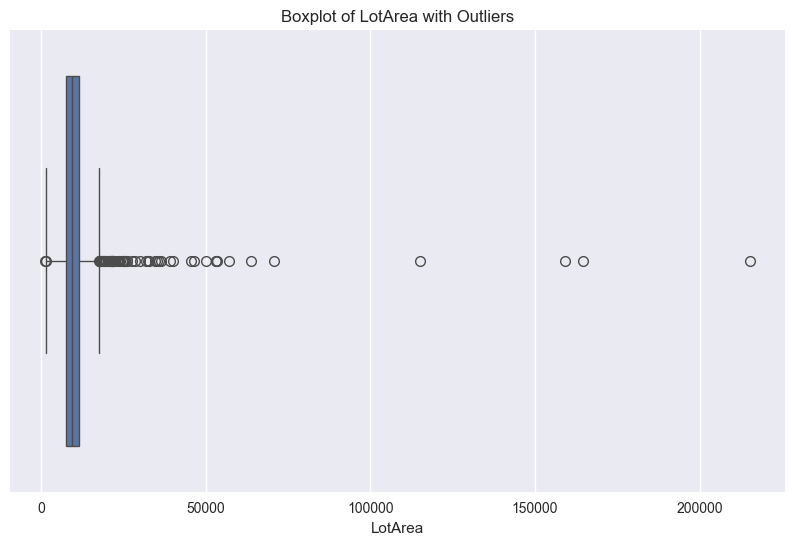

In [36]:
# Boxplot to visualize the distribution and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['LotArea'])
plt.title('Boxplot of LotArea with Outliers')
plt.xlabel('LotArea')
plt.show()

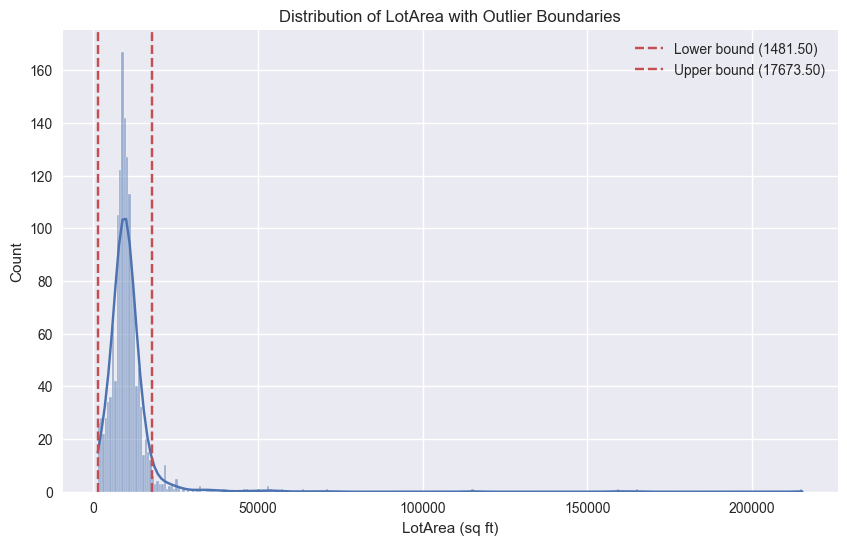

In [37]:
# Histogram to show the distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['LotArea'], kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Distribution of LotArea with Outlier Boundaries')
plt.xlabel('LotArea (sq ft)')
plt.legend()
plt.show()

In [38]:
# Compare statistics before and after outlier removal
print("\nStatistics before outlier removal:")
print(train_df['LotArea'].describe())
print("\nStatistics after outlier removal:")
print(train_df_clean['LotArea'].describe())


Statistics before outlier removal:
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Statistics after outlier removal:
count     1391.000000
mean      9272.537024
std       3196.732418
min       1491.000000
25%       7429.000000
50%       9286.000000
75%      11231.500000
max      17671.000000
Name: LotArea, dtype: float64


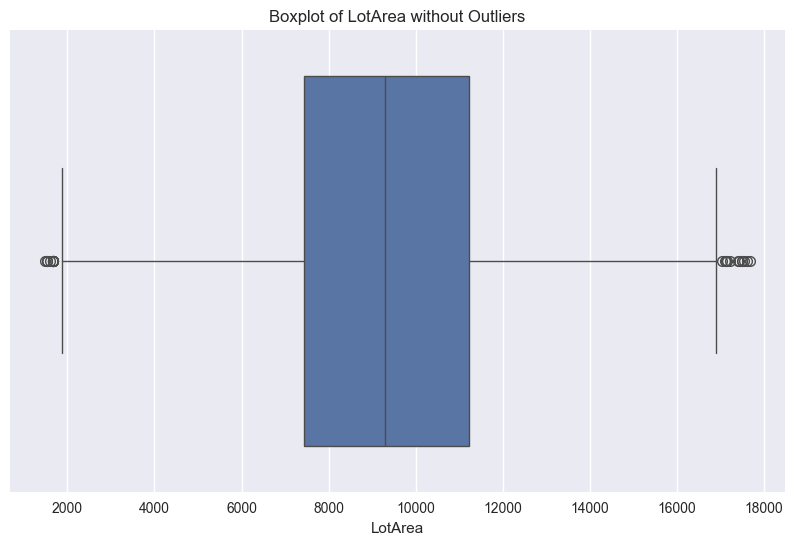

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df_clean['LotArea'])
plt.title('Boxplot of LotArea without Outliers')
plt.xlabel('LotArea')
plt.show()

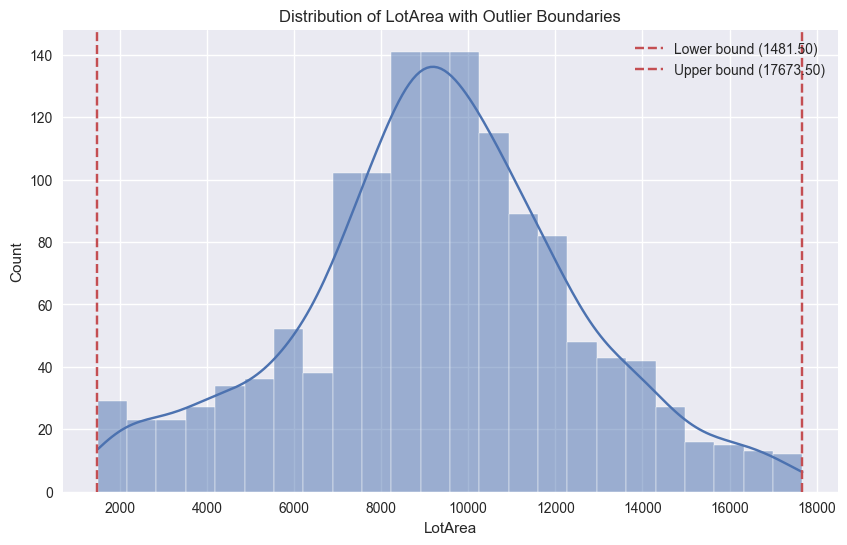

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df_clean['LotArea'], kde=True)
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
plt.title('Distribution of LotArea with Outlier Boundaries')
plt.xlabel('LotArea')
plt.legend()
plt.show()

## Semi-supervised and Unsupervised methods

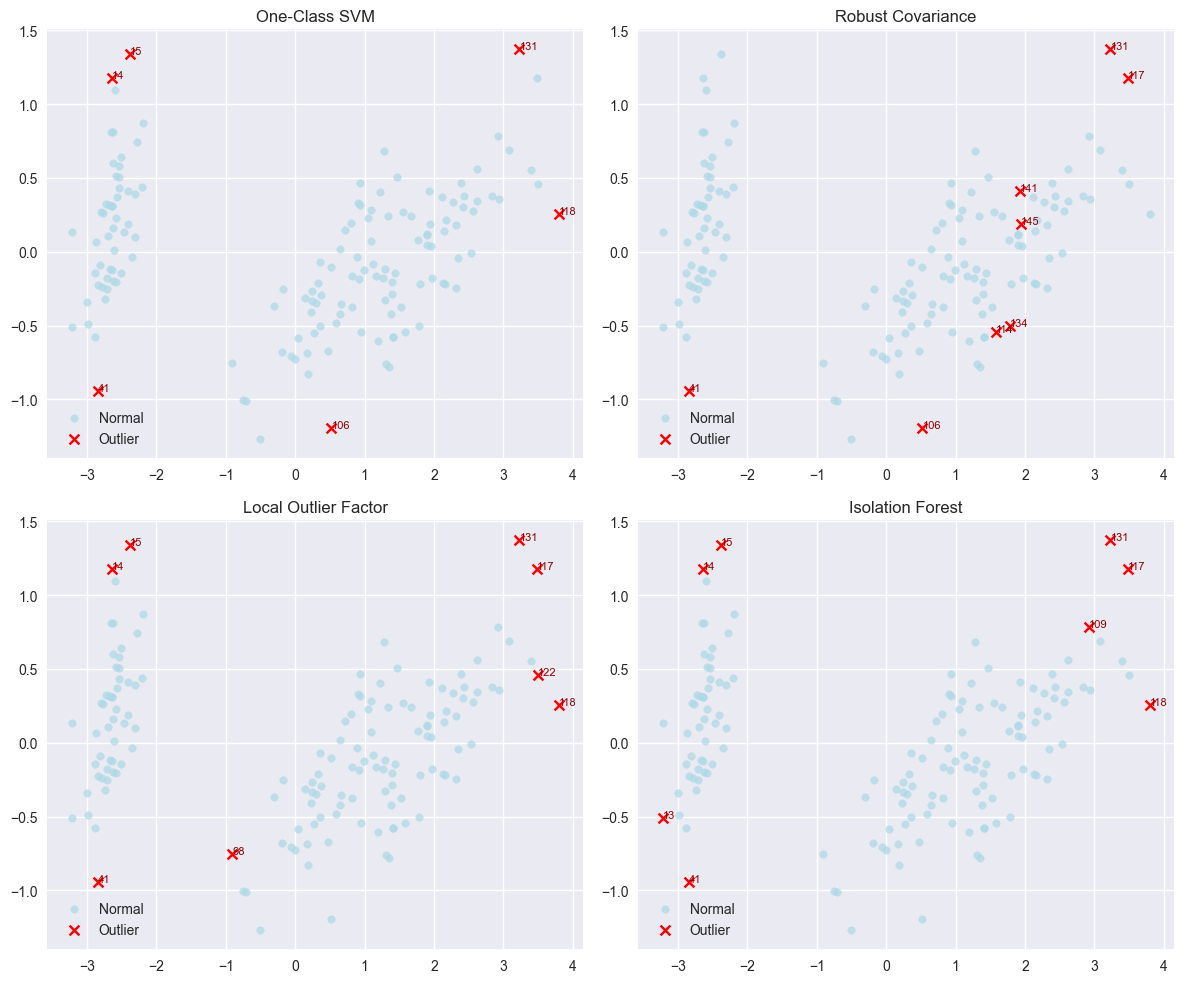

In [41]:
# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target 

# Dimensionality reduction (2D PCA projection)
pca = sklearnPCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define outlier detection models
models = {
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1), 
    "Robust Covariance": EllipticEnvelope(contamination=0.05, support_fraction=1.0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.05, metric="euclidean"),
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42)
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, (name, model) in enumerate(models.items()):
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X)
    else:
        model.fit(X)
        y_pred = model.predict(X)
    
    # Standardize labels: anomaly = -1, normal = 1
    anomalies = (y_pred == -1)
    
    # Plot
    axs[i].scatter(X_2d[~anomalies, 0], X_2d[~anomalies, 1],
                   c="lightblue", label="Normal", s=30, alpha=0.7)
    axs[i].scatter(X_2d[anomalies, 0], X_2d[anomalies, 1],
                   c="red", label="Outlier", s=50, marker="x")
    
    # Annotate anomaly points
    for idx in np.where(anomalies)[0]:
        #print(f"Anomaly detected at index {idx} with coordinates {X_2d[idx]}")
        axs[i].annotate(str(idx), (X_2d[idx, 0], X_2d[idx, 1]),
                        fontsize=8, color="darkred")
    
    axs[i].set_title(name)
    axs[i].legend()

plt.tight_layout()
plt.show()


Subset shapes: (100, 4) (100,)
Normal (Virginica): 50, Outlier (Versicolor): 50


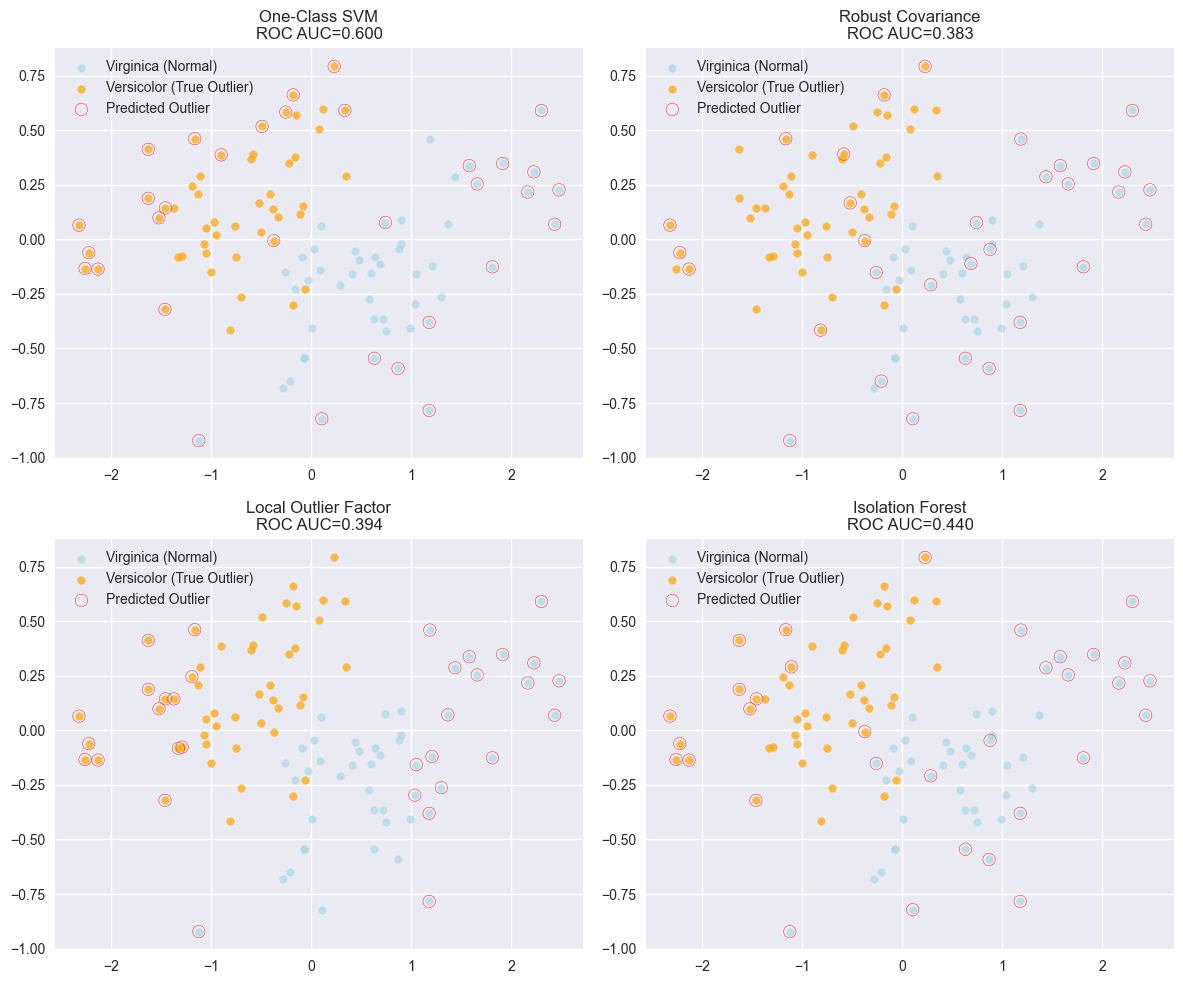

ROC AUC results :
One-Class SVM       : 0.600
Robust Covariance   : 0.383
Local Outlier Factor: 0.394
Isolation Forest    : 0.440


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

# Load dataset (only Versicolor & Virginica)
iris = load_iris()
X = iris.data
y = iris.target

# Keeping only classes 1 (versicolor) and 2 (virginica)
mask = (y != 0)
X = X[mask]
y = y[mask]

# treat Virginica (class=2) as "normal" (0), Versicolor (class=1) as "outlier" (1)
y_binary = (y == 1).astype(int)

contamination_rate = np.sum(y_binary) / X.shape[0]

print("Subset shapes:", X.shape, y_binary.shape)
print(f"Normal (Virginica): {np.sum(y_binary==0)}, Outlier (Versicolor): {np.sum(y_binary==1)}")

# Dimensionality reduction for visualization
pca = sklearnPCA(n_components=2)
X_2d = pca.fit_transform(X)

# Define outlier detection models
models = {
    "One-Class SVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1),
    "Robust Covariance": EllipticEnvelope(contamination=contamination_rate, support_fraction=1.0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=int(X.shape[0] * y_binary.mean()), contamination=0.33, metric="euclidean"),
    "Isolation Forest": IsolationForest(contamination=contamination_rate, random_state=42)
}

# Fit, predict & evaluate
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

results_auc = {}

for i, (name, model) in enumerate(models.items()):
    if name == "Local Outlier Factor":
        model.fit(X)  
        scores = -model.negative_outlier_factor_ 
        #scores = model[-1].negative_outlier_factor_
    else:
        model.fit(X)
        scores = -model.decision_function(X)
    
    # Predict anomalies
    preds = (scores > np.percentile(scores, 67)).astype(int)
    
    # ROC AUC evaluation
    auc = roc_auc_score(y_binary, scores)
    results_auc[name] = auc
    
    # Visualization
    axs[i].scatter(X_2d[y_binary == 0, 0], X_2d[y_binary == 0, 1],
                   c="lightblue", label="Virginica (Normal)", s=30, alpha=0.7)
    axs[i].scatter(X_2d[y_binary == 1, 0], X_2d[y_binary == 1, 1],
                   c="orange", label="Versicolor (True Outlier)", s=30, alpha=0.7)
    axs[i].scatter(X_2d[preds == 1, 0], X_2d[preds == 1, 1],
                   facecolors='none', edgecolors='red', marker="o", s=80,
                   label="Predicted Outlier")
    
    axs[i].set_title(f"{name}\nROC AUC={auc:.3f}")
    axs[i].legend(loc="best")

plt.tight_layout()
plt.show()

# Print AUC scores summary
print("ROC AUC results :")
for name, auc in results_auc.items():
    print(f"{name:20s}: {auc:.3f}")


## Outlier Detection on Kursawe Benchmark

Problem name: <bound method Problem.name of <pymoo.problems.multi.kursawe.Kursawe object at 0x000001DD6C281950>>
Number of variables: 3
Lower bounds: [-5. -5. -5.]
Upper bounds: [5. 5. 5.]
Number of objectives: 2
Number of constraints: 0
X first values: [[ 1.46868716  0.22831133 -4.61711414]
 [ 1.43936618  4.11980061  3.65227191]
 [ 0.73201045 -0.39415784 -4.10743882]
 [-3.9968063   2.18247569 -0.26898636]
 [-2.47314211  4.61408779  0.06401733]]
X shape: (200, 3) y shape: (200,)
Injected 20 outliers


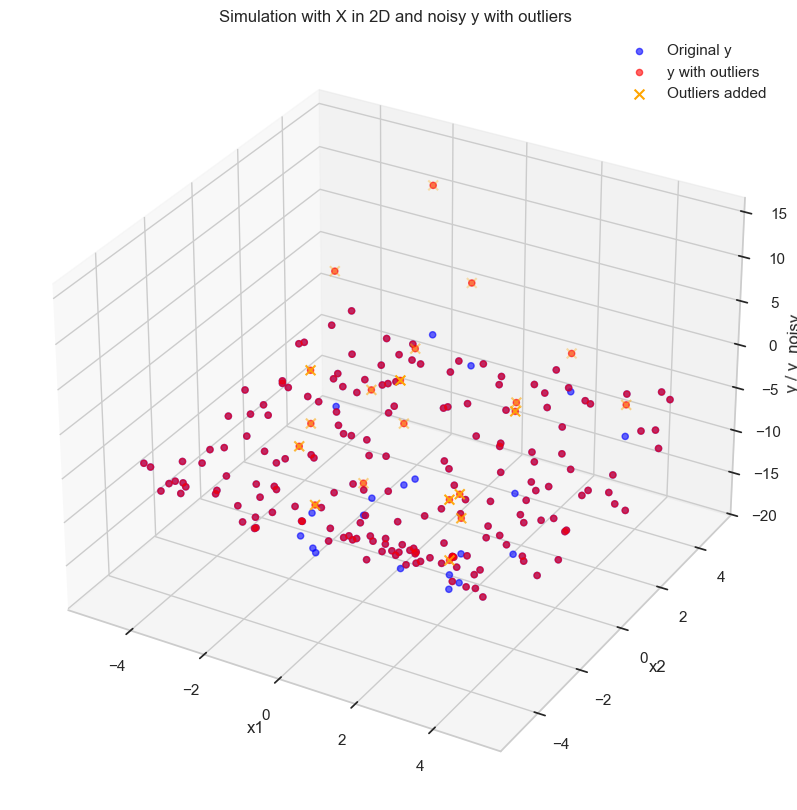


Detection summary (vs injected ground truth):
IsolationForest     flagged= 20 | TP=  2  FP= 18  FN= 18
LocalOutlierFactor  flagged= 20 | TP=  2  FP= 18  FN= 18
OneClassSVM         flagged= 31 | TP=  6  FP= 25  FN= 14
EllipticEnvelope    flagged= 20 | TP=  2  FP= 18  FN= 18


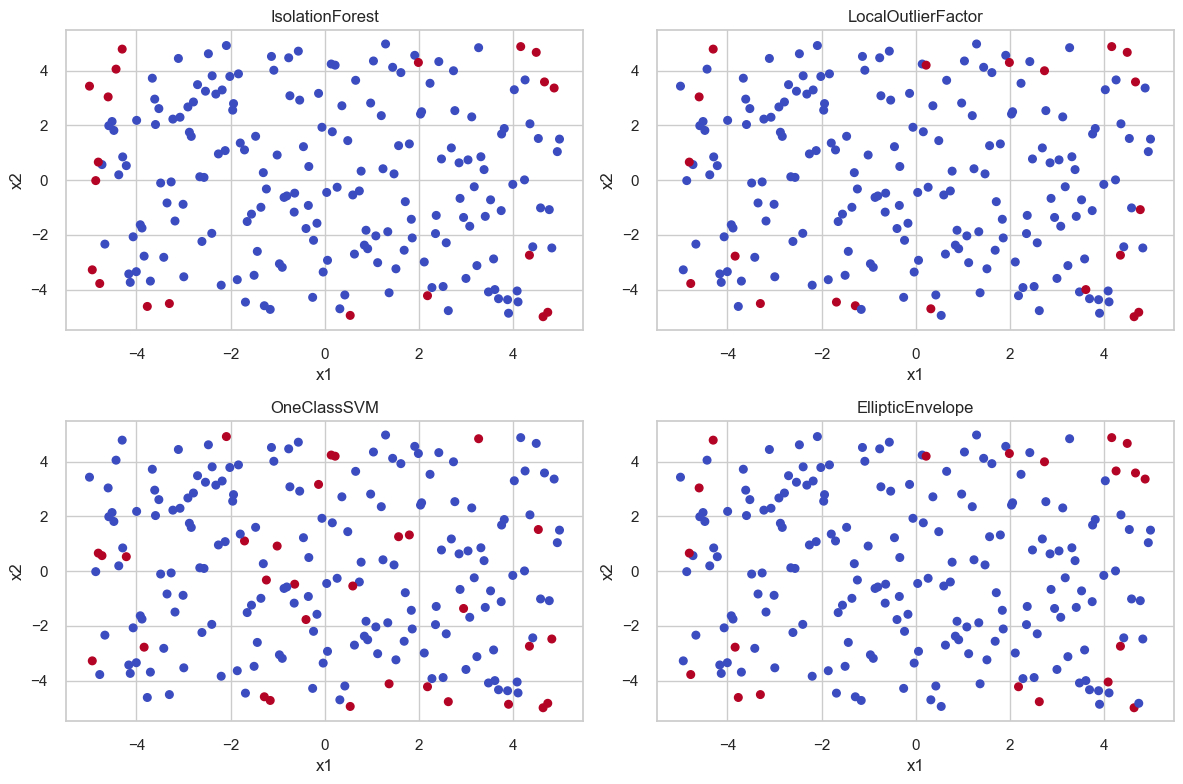

In [43]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from pymoo.problems import get_problem
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

sns.set(style="whitegrid")

# Loading Kursawe problem (3D input, 2 objectives)
problem = get_problem("kursawe")

print("Problem name:", problem.name)
print("Number of variables:", problem.n_var)
print("Lower bounds:", problem.xl)
print("Upper bounds:", problem.xu)
print("Number of objectives:", problem.n_obj)
print("Number of constraints:", problem.n_constr)

N = 200  # Number of samples

# Generating random design of experiments
#X = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))

# Generating latin hypercube samples
sampling = LatinHypercubeSampling()
X = sampling.do(problem, N).get("X") 

F = problem.evaluate(X)

# Use only the first objective for simplicity
y = F[:, 0]
print("X first values:", X[:5])
print("X shape:", X.shape, "y shape:", y.shape)

# Inject artificial outliers in y
n_outliers = int(0.10 * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()
y_noisy[outlier_idx] += np.random.normal(10, 5, size=n_outliers)

mask_injected = np.zeros(N, dtype=bool)
mask_injected[outlier_idx] = True


print(f"Injected {n_outliers} outliers")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
 
# Visualizing points with outliers
ax.scatter(X[:, 0], X[:, 1], y, label="Original y", color="blue", alpha=0.6)  
ax.scatter(X[:, 0], X[:, 1], y_noisy, label="y with outliers", color="red", alpha=0.6)
ax.scatter(X[outlier_idx, 0], X[outlier_idx, 1], y_noisy[outlier_idx], 
           color="orange", label="Outliers added", s=50, marker="x")
 
ax.set_title("Simulation with X in 2D and noisy y with outliers")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y / y_noisy")
ax.legend()
plt.show()

def report(name, preds, mask_injected):
    mask = preds == -1 # outliers detected
    tp = np.sum(mask & mask_injected)
    fp = np.sum(mask & ~mask_injected)
    fn = np.sum(~mask & mask_injected)
    print(f"{name:18s}  flagged={mask.sum():3d} | TP={tp:3d}  FP={fp:3d}  FN={fn:3d}")



# Apply outlier detection methods
detectors = {
    "IsolationForest": IsolationForest(contamination=0.1, random_state=42),
    "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    "OneClassSVM": OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.1, random_state=42)
}

results = {}
for name, clf in detectors.items():
    if name == "LocalOutlierFactor":
        preds = clf.fit_predict(X)
    else:
        preds = clf.fit(X).predict(X)
    results[name] = preds

print("\nDetection summary (vs injected ground truth):")
for name, preds in results.items():
    report(name, preds, mask_injected)


# Visualization after applying outlier detection methods
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
#axs = [fig.add_subplot(2, 2, i+1, projection='3d') for i in range(4)]

for i, (name, preds) in enumerate(results.items()):
    axs[i].scatter(X[:, 0], X[:, 1], c=(preds == -1), cmap="coolwarm", s=30)
    axs[i].set_title(name)
    axs[i].set_xlabel("x1")
    axs[i].set_ylabel("x2")

plt.tight_layout()
plt.show()





=== Evaluation wither scaler: Standard ===

=== Evaluation wither scaler: Robust ===

=== Evaluation wither scaler: None ===

=== Best Configurations ===
                Method    Scaler  Precision  Recall  F1-Score     AUC
0      IsolationForest  Standard     0.0725  0.0725    0.0725  0.4811
1   LocalOutlierFactor  Standard     0.0800  0.0800    0.0800  0.5000
2          OneClassSVM  Standard     0.0667  0.0675    0.0671  0.4690
3     RobustCovariance  Standard     0.0700  0.0700    0.0700  0.4843
4      IsolationForest    Robust     0.0725  0.0725    0.0725  0.4811
5   LocalOutlierFactor    Robust     0.0800  0.0800    0.0800  0.5000
6          OneClassSVM    Robust     0.0642  0.0650    0.0646  0.4690
7     RobustCovariance    Robust     0.0700  0.0700    0.0700  0.4843
8      IsolationForest      None     0.0725  0.0725    0.0725  0.4811
9   LocalOutlierFactor      None     0.0800  0.0800    0.0800  0.5000
10         OneClassSVM      None     0.0668  0.0675    0.0672  0.4685
11   

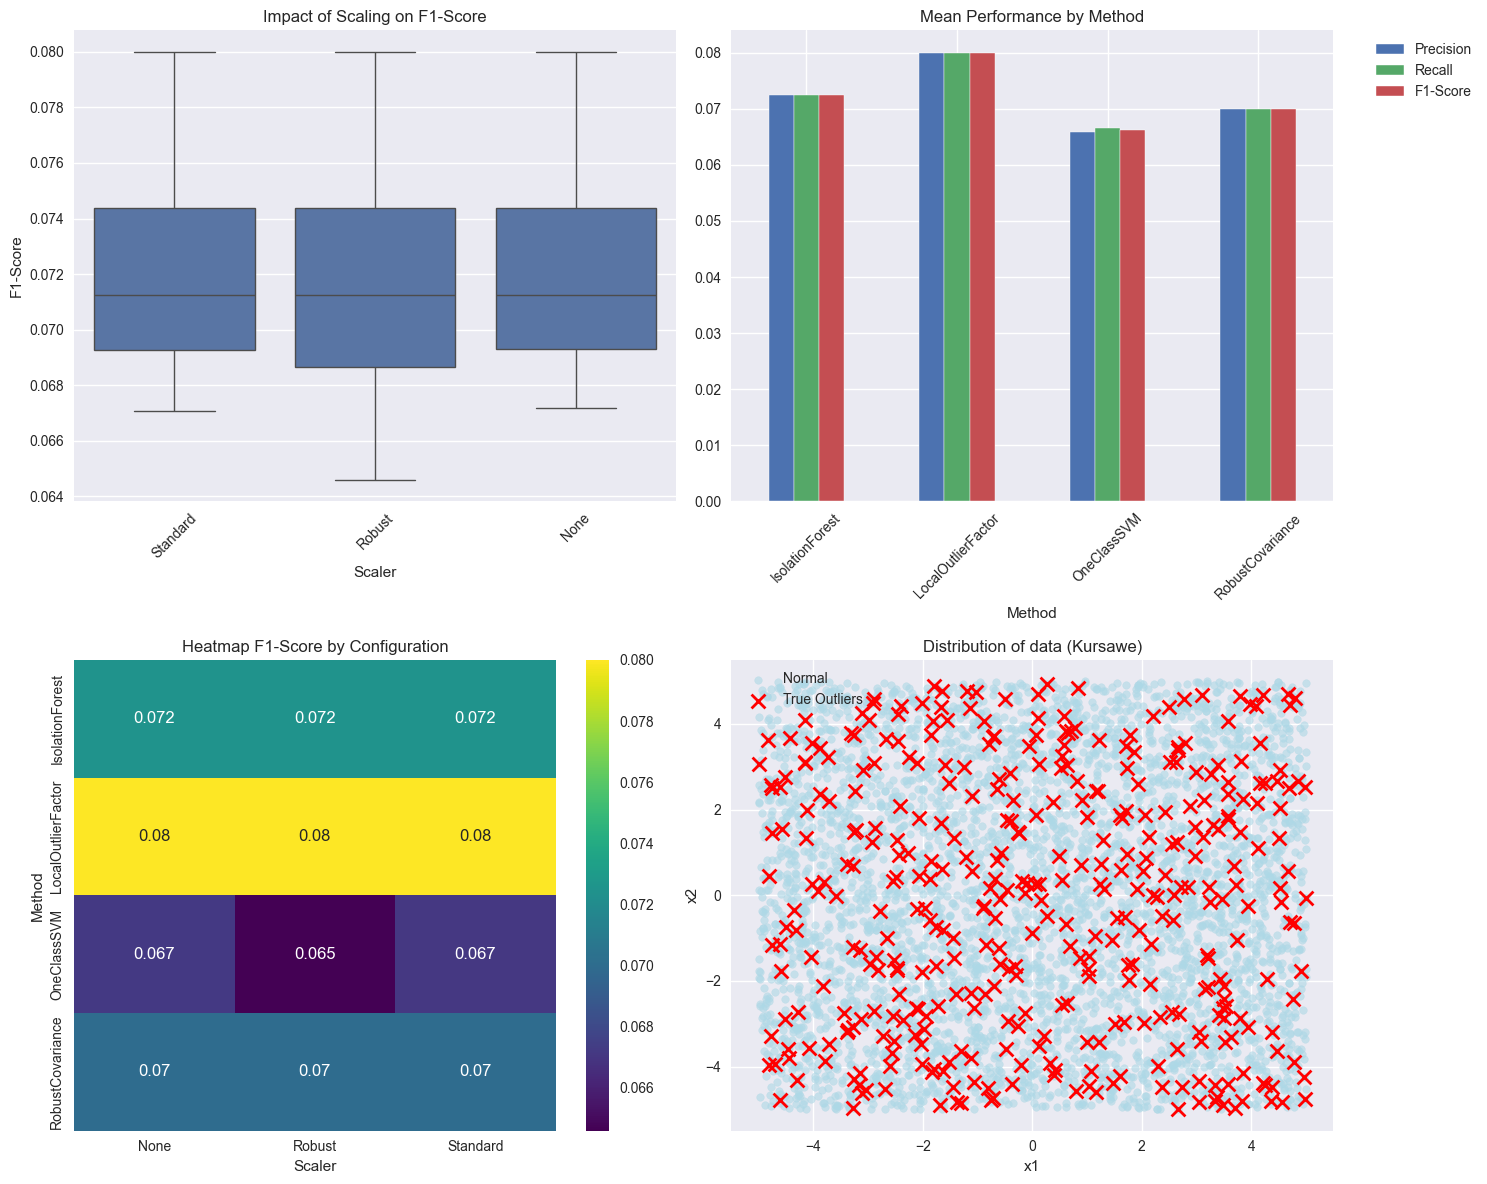

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from pymoo.problems import get_problem
import seaborn as sns

plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Generating data with preprocessing
problem = get_problem("kursawe")
N = 5000
X_raw = np.random.uniform(problem.xl, problem.xu, size=(N, problem.n_var))
F = problem.evaluate(X_raw)
y = F[:, 0]

# Outlier injection
frac_outliers = 0.08
n_outliers = int(frac_outliers * N)
outlier_idx = np.random.choice(N, n_outliers, replace=False)
y_noisy = y.copy()


noise_levels = np.random.choice([5, 8, 12], size=n_outliers, p=[0.5, 0.3, 0.2])
y_noisy[outlier_idx] += np.random.normal(0, noise_levels)

mask_true_outliers = np.zeros(N, dtype=bool)
mask_true_outliers[outlier_idx] = True

# Data preprocessing
scalers = {
    'Standard': StandardScaler(),
    'Robust': RobustScaler(),
    'None': None
}


def get_improved_detectors(contamination_rate):
    return {
        "IsolationForest_Optimized": IsolationForest(
            contamination=contamination_rate,
            n_estimators=200,          
            max_samples='auto',        
            max_features=1.0,          
            random_state=42,
            bootstrap=False            
        ),
        
        "LocalOutlierFactor_Tuned": LocalOutlierFactor(
            n_neighbors=max(20, int(0.02 * N)),  
            contamination=contamination_rate,
            algorithm='ball_tree',      
            leaf_size=30,
            metric='minkowski',
            p=2,                       
            novelty=False
        ),
        
        "OneClassSVM_Enhanced": OneClassSVM(
            nu=contamination_rate,
            kernel="rbf",
            gamma='scale',             
            tol=1e-4,                 
            shrinking=True,           
            cache_size=1000           
        ),
        
        "RobustCovariance_Improved": EllipticEnvelope(
            contamination=contamination_rate,
            support_fraction=None,     
            random_state=42,
            assume_centered=False,     
            store_precision=True       
        )
    }

# Evaluating different scalers
results = []

for scaler_name, scaler in scalers.items():
    print(f"\n=== Evaluation wither scaler: {scaler_name} ===")
    
    # Preprocessing
    if scaler is not None:
        X_scaled = scaler.fit_transform(X_raw)
    else:
        X_scaled = X_raw.copy()
    
    detectors = get_improved_detectors(frac_outliers)
    
    for name, model in detectors.items():
        try:
            # Prediction
            if "LocalOutlier" in name:
                preds = model.fit_predict(X_scaled)
            else:
                preds = model.fit(X_scaled).predict(X_scaled)
            
            mask_pred = preds == -1
            
            # Compute metrics
            tp = np.sum(mask_pred & mask_true_outliers)
            fp = np.sum(mask_pred & ~mask_true_outliers)
            fn = np.sum(~mask_pred & mask_true_outliers)
            tn = np.sum(~mask_pred & ~mask_true_outliers)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            # AUC probabilities scores
            if hasattr(model, 'decision_function'):
                scores = model.decision_function(X_scaled)
                auc = roc_auc_score(mask_true_outliers, -scores) 
                scores = model.score_samples(X_scaled)
                auc = roc_auc_score(mask_true_outliers, -scores)
            else:
                auc = roc_auc_score(mask_true_outliers, mask_pred.astype(int))
            
            results.append({
                "Scaler": scaler_name,
                "Method": name.replace('_Optimized', '').replace('_Tuned', '').replace('_Enhanced', '').replace('_Improved', ''),
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "Specificity": specificity,
                "AUC": auc,
                "TP": tp,
                "FP": fp,
                "FN": fn
            })
            
        except Exception as e:
            print(f"Erreur avec {name}: {e}")
            continue

# Results analysis
df_results = pd.DataFrame(results)

# Best configuration for each method
#best_configs = df_results.loc[df_results.groupby('Method')['F1-Score'].idxmax()]
best_configs = df_results

print("\n=== Best Configurations ===")
print(best_configs[['Method', 'Scaler', 'Precision', 'Recall', 'F1-Score', 'AUC']].round(4))


# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance by scaler
sns.boxplot(data=df_results, x='Scaler', y='F1-Score', ax=axes[0,0])
axes[0,0].set_title('Impact of Scaling on F1-Score')
axes[0,0].tick_params(axis='x', rotation=45)

# Performance by method
method_perf = df_results.groupby('Method')[['Precision', 'Recall', 'F1-Score']].mean()
method_perf.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Mean Performance by Method')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].tick_params(axis='x', rotation=45)

# Heatmap of performances
pivot_f1 = df_results.pivot(index='Method', columns='Scaler', values='F1-Score')
sns.heatmap(pivot_f1, annot=True, cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Heatmap F1-Score by Configuration')

# Distribution of detected outliers
axes[1,1].scatter(X_raw[:, 0], X_raw[:, 1], c='lightblue', s=30, alpha=0.6, label='Normal')
axes[1,1].scatter(X_raw[outlier_idx, 0], X_raw[outlier_idx, 1], 
                 c='red', marker='x', s=100, linewidths=2, label='True Outliers')
axes[1,1].set_title('Distribution of data (Kursawe)')
axes[1,1].set_xlabel('x1')
axes[1,1].set_ylabel('x2')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Outlier Detection on Benchmarks

For each benchmark we:
1. Generate a **Latin Hypercube Sampling (LHS)** Design of Experiments (DoE)
2. Evaluate the problem to get the target `y`
3. **Inject output outliers** into `y` (percentage depends)
4. Run statistical methods (mostly on `y` or joint `[X, y]`) and ML methods (on **augmented features** `[X, y]` to capture output anomalies)
5. Report **Precision, Recall, F1-score, ROC-AUC** and draw the **ROC curve** with `RocCurveDisplay`

> Note: Since we inject outliers in **Y**, ML methods are run on the augmented feature set `[X, y_noisy]` so they can learn the joint pattern and flag inconsistencies in the output.

Benchmarks used for illustration are :

| **Benchmark**   | **Landscape** | **Characteristics** |
|----------------|---------------|----------------------|
| **Schwefel**   | Highly multimodal, many local minima, global min far from origin | Rugged, irregular surface with deceptive valleys |
| **Rosenbrock** | Unimodal with a narrow, curved valley | Smooth but ill-conditioned, long flat regions |
| **Ackley**     | Multimodal with many local minima | Flat outer regions with sharp global basin | 
| **Kursawe**    | Non-linear, non-convex, disjoint Pareto fronts (multi-objective) | Mix of smooth parts and discontinuities |
| **Rastrigin**  | Strongly multimodal, many regularly spaced minima | Periodic, structured wave-like patterns |
| **Sphere**     | Simple, convex, unimodal | Smooth, symmetric quadratic growth |
| **Griewank**   | Many regularly distributed local minima | Oscillatory, flat regions, less multimodality than Rastrigin |



In [45]:
class Benchmark:
    def __init__(self, name: str, dim: int = None):
        self.name = name.lower()
        self.dim = dim
        
        if self.name == "rosenbrock":
            if self.dim is None:
                raise ValueError("Set dim for Rosenbrock")
            self.problem = get_problem("rosenbrock", n_var=self.dim)
        elif self.name == "kursawe":
            self.problem = get_problem("kursawe")
            self.dim = self.problem.n_var
        elif self.name == "sphere":
            if self.dim is None:
                self.dim = 2
            self.problem = get_problem("sphere", n_var=self.dim)
        else:
            self.problem = get_problem(self.name, n_var=self.dim)
            if self.dim is None:
                self.dim = self.problem.n_var
        
        self.bounds = np.vstack([self.problem.xl, self.problem.xu]).T

    # DoE generators
    def sample_sobol(self, n_points: int, scramble: bool = True):
        sampler = qmc.Sobol(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_halton(self, n_points: int, scramble: bool = True):
        sampler = qmc.Halton(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_lhs(self, n_points: int, criterion: str = "random-cd", seed: int = 42): # values of criterion : 'random-cd', 'lloyd'
        sampler = qmc.LatinHypercube(d=self.dim, optimization=criterion, seed=seed)
        sample = sampler.random(n_points)
        print("LHS discrepancy:", qmc.discrepancy(sample))
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])

    def evaluate(self, X: np.ndarray):
        return self.problem.evaluate(X)
    
    def inject_outliers(self, X, Y, frac: float = 0.05, scale_factor: float = 0.2):
        """Inject near-outliers into Y (output). Returns noisy Y and indices of injected outliers."""
        n_outliers = max(1, int(frac * X.shape[0]))
        idx = np.random.choice(X.shape[0], n_outliers, replace=False)
        Y_out = Y.copy()
        scale = np.std(Y, axis=0) * scale_factor
        if Y_out.ndim == 1:
            Y_out[idx] = Y_out[idx] + np.random.normal(0, scale, size=n_outliers)
        else:
            Y_out[idx, 0] = Y_out[idx, 0] + np.random.normal(0, scale, size=n_outliers)
        return Y_out, idx

In [46]:
class StatisticalOutlierDetection:
    def z_score(self, data, threshold: float = 3.0):
        z_scores = np.abs(stats.zscore(data, axis=0))
        scores = np.max(z_scores, axis=1)
        return scores > threshold, scores

    def iqr(self, data, factor: float = 1.5):
        Q1 = np.percentile(data, 25, axis=0)
        Q3 = np.percentile(data, 75, axis=0)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = np.any((data < lower) | (data > upper), axis=1)
        dist = np.max(np.maximum(0, data - upper) + np.maximum(0, lower - data), axis=1)
        return mask, dist

    def leverage(self, X, threshold: float = None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        if threshold is None:
            threshold = 2 * X_design.shape[1] / X_design.shape[0]
        return leverages > threshold, leverages

    def cooks_distance(self, X, y, threshold: float = None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = y.ravel()
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        p = X_design.shape[1]
        n = X_design.shape[0]
        mse = np.sum(residuals**2) / max(1, (n - p))
        cooks_d = (residuals**2 / (p * mse)) * (leverages / (1 - leverages)**2)
        if threshold is None:
            threshold = 4 / n
        return cooks_d > threshold, cooks_d

    def mahalanobis(self, X, threshold: float = None):
        cov = EmpiricalCovariance().fit(X)
        m_dist = cov.mahalanobis(X)
        if threshold is None:
            # Use a high percentile as a generic cutoff; ROC will use the full score anyway
            threshold = np.percentile(m_dist, 97.5)
        return m_dist > threshold, m_dist

In [47]:
class MLOutlierDetection:

    def __init__(self):
        self.scaler = StandardScaler()

    def elliptic_envelope(self, X, contamination: float = 0.1):
        model = EllipticEnvelope(contamination=contamination, random_state=42)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def isolation_forest(self, X, contamination: float = 0.1):
        model = IsolationForest(contamination=contamination, random_state=42)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def lof(self, X, contamination: float = 0.1, n_neighbors: int = 20):
        model = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
        pred = model.fit_predict(X)
        return pred == -1, -model.negative_outlier_factor_

    def one_class_svm(self, X, nu: float = 0.1):
        model = OneClassSVM(gamma="scale", nu=nu)
        pred = model.fit_predict(X)
        return pred == -1, -model.decision_function(X)

    def sgd_one_class_svm(self, X, nu: float = 0.1):
        try:
            model = SGDOneClassSVM(nu=nu, random_state=42)
            pred = model.fit_predict(X)
            return pred == -1, -model.decision_function(X)
        except Exception:
            # If not available in the local sklearn version, return blanks
            return np.zeros(X.shape[0], dtype=bool), np.zeros(X.shape[0])
        
    def dbscan(self, X, eps: float = 0.5, min_samples: int = 5):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X)
        outliers = labels == -1
        # Since DBSCAN doesn't provide anomaly scores, I set score=1 for outliers, 0 otherwise
        scores = outliers.astype(int)
        return outliers, scores

In [48]:
scale_factor_extreme = 10.0
scale_factor_near = 0.5

y_true = {}
y_score = {"Z-Score (Extreme)": {}, "IQR (Extreme)": {}, "Leverage (Extreme)": {}, "Cook's Distance (Extreme)": {}, "Mahalanobis (Extreme)": {},
           "Elliptic Envelope (Extreme)": {}, "Isolation Forest (Extreme)": {}, "LOF (Extreme)": {}, "One-Class SVM (Extreme)": {}, "SGD One-Class SVM (Extreme)": {}, "DBSCAN (Extreme)": {},
           "Z-Score (Near)": {}, "IQR (Near)": {}, "Leverage (Near)": {}, "Cook's Distance (Near)": {}, "Mahalanobis (Near)": {},
           "Elliptic Envelope (Near)": {}, "Isolation Forest (Near)": {}, "LOF (Near)": {}, "One-Class SVM (Near)": {}, "SGD One-Class SVM (Near)": {}, "DBSCAN (Near)": {}}
model_names = ["Z-Score (Extreme)", "IQR (Extreme)", "Leverage (Extreme)", "Cook's Distance (Extreme)", "Mahalanobis (Extreme)",
               "Elliptic Envelope (Extreme)", "Isolation Forest (Extreme)", "LOF (Extreme)", "One-Class SVM (Extreme)", "SGD One-Class SVM (Extreme)", "DBSCAN (Extreme)",
               "Z-Score (Near)", "IQR (Near)", "Leverage (Near)", "Cook's Distance (Near)", "Mahalanobis (Near)",
               "Elliptic Envelope (Near)", "Isolation Forest (Near)", "LOF (Near)", "One-Class SVM (Near)", "SGD One-Class SVM (Near)", "DBSCAN (Near)"]

In [49]:
def evaluate_detection(true_idx, pred_mask, scores, method_name, duration, roc_curve=False):
    y_true = np.zeros(len(pred_mask), dtype=int)
    y_true[true_idx] = 1
    y_pred = pred_mask.astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Normalize scores to [0,1] for ROC AUC (higher = more anomalous)
    scores = np.asarray(scores)
    if np.max(scores) > np.min(scores):
        scores_norm = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    else:
        scores_norm = scores
    auc = roc_auc_score(y_true, scores_norm)

    print(f"{method_name:25s} | Precision={precision:.2f}  Recall={recall:.2f}  F1={f1:.2f}  AUC={auc:.2f}  Time={duration:.4f}s")
    if roc_curve:
        RocCurveDisplay.from_predictions(y_true, scores_norm, name=method_name)
        plt.show()
    return y_true, scores_norm

In [50]:
def plot_benchmark(benchmark_name, X, y, figsize=(12, 4)):   
    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: 2D scatter of input space colored by function value
    if X.shape[1] >= 2:
        scatter = axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, s=20)
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        axes[0].set_title(f'{benchmark_name.title()} - Input Space')
        plt.colorbar(scatter, ax=axes[0])
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].scatter(X[:, 0], y, alpha=0.7, s=20)
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('Y')
        axes[0].set_title(f'{benchmark_name.title()} - Function Values')
        axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Distribution of function values
    axes[1].hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Function Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{benchmark_name.title()} - Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [51]:
def run_detection(X, y_noisy, idx, bench_name, contamination_rate, stat, ml, y_score, y_true, label_suffix="", eps: float = 0.5, min_samples: int = 5):
    """Apply statistical + ML outlier detection methods and store results."""
 
    # Statistical on y only
    t0 = time()
    mask, scores = stat.z_score(y_noisy.reshape(-1,1))
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Z-Score" + label_suffix, duration=t1 - t0)
    y_score["Z-Score" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time()
    mask, scores = stat.iqr(y_noisy.reshape(-1,1), factor=1.5)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "IQR" + label_suffix, duration=t1 - t0)
    y_score["IQR" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    # Statistical on joint [X, y]
    X_aug = np.hstack([X, y_noisy.reshape(-1,1)])
    t0 = time()
    mask, scores = stat.mahalanobis(X_aug)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Mahalanobis" + label_suffix, duration=t1 - t0)
    y_score["Mahalanobis" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time()
    mask, scores = stat.leverage(X)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Leverage" + label_suffix, duration=t1 - t0)
    y_score["Leverage" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time()
    mask, scores = stat.cooks_distance(X, y_noisy)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Cook's Distance" + label_suffix, duration=t1 - t0)
    y_score["Cook's Distance" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    # ML methods on joint [X, y]
    X_aug = ml.scaler.fit_transform(X_aug)
 
    t0 = time()
    mask, scores = ml.elliptic_envelope(X_aug, contamination=contamination_rate)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Elliptic Envelope" + label_suffix, duration=t1 - t0)
    y_score["Elliptic Envelope" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time() 
    mask, scores = ml.isolation_forest(X_aug, contamination=contamination_rate)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "Isolation Forest" + label_suffix, duration=t1 - t0)
    y_score["Isolation Forest" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time()
    mask, scores = ml.lof(X_aug, contamination=contamination_rate, n_neighbors=max(20, int(contamination_rate * len(X))))
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "LOF" + label_suffix, duration=t1 - t0)
    y_score["LOF" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time()
    mask, scores = ml.one_class_svm(X_aug, nu=contamination_rate)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "One-Class SVM" + label_suffix, duration=t1 - t0)
    y_score["One-Class SVM" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred
 
    t0 = time()
    mask, scores = ml.sgd_one_class_svm(X_aug, nu=contamination_rate)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "SGD One-Class SVM" + label_suffix, duration=t1 - t0)
    y_score["SGD One-Class SVM" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred

    t0 = time()
    mask, scores = ml.dbscan(X_aug, eps=eps, min_samples=min_samples)
    t1 = time()
    y_true_pred, y_score_norm = evaluate_detection(idx, mask, scores, "DBSCAN" + label_suffix, duration=t1 - t0)
    y_score["DBSCAN" + label_suffix][bench_name] = y_score_norm
    y_true[bench_name] = y_true_pred

In [84]:
def run_detection_pyod(X, y_noisy, idx, n_clusters: int = 8, contamination_rate: float=0.5):
    
    # ground truth: 1 = outlier, 0 = normal
    y_true = np.zeros(X.shape[0], dtype=int)
    y_true[idx] = 1

    random_state = np.random.RandomState(42)

    classifiers = {
        "Angle-based Outlier Detector": ABOD(contamination=contamination_rate),
        'Feature Bagging': FeatureBagging(contamination=contamination_rate, random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=contamination_rate),
        "Isolation Forest": IForest(contamination=contamination_rate, random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=contamination_rate),
        "LOF": LOF(contamination=contamination_rate),
        #"LOCI": LOCI(contamination=contamination_rate),
        'Minimum Covariance Determinant (MCD)': MCD(contamination=contamination_rate, random_state=random_state),
        'One-class SVM (OCSVM)': OCSVM(contamination=contamination_rate),
        'Principal Component Analysis (PCA)': PCA(contamination=contamination_rate, random_state=random_state),
        "COPOD": COPOD(),
        'Cluster-based Local Outlier Factor': CBLOF(n_clusters= n_clusters, contamination=contamination_rate, check_estimator=False, random_state=random_state),
        #"DBSCAN" : DBSCAN()
    }

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.4, random_state=random_state)

    X_aug_train = np.hstack([X_train, y_train.reshape(-1,1)])
    X_aug_test = np.hstack([X_test, y_test.reshape(-1,1)])

    # X_aug_train = np.hstack([X_train, y_noisy[:len(X_train)].reshape(-1,1)])
    # X_aug_test = np.hstack([X_test, y_noisy[len(X_train):].reshape(-1,1)])

    # X_aug_train = X_train
    # X_aug_test = X_test

    # Standardize data
    X_train_norm, X_test_norm = standardizer(X_aug_train, X_aug_test)

    for clf_name, clf in classifiers.items():
        try:
            t0 = time()
            clf.fit(X_train_norm)
            test_scores = clf.decision_function(X_test_norm)
            t1 = time()
            duration = round(t1 - t0, 4)

            roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
            prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
            
            #y_pred = clf.predict(X_test_norm)
            #mask = y_pred == 1
            
            print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
                    'execution time: {duration}s'.format(
                    clf_name=clf_name, roc=roc, prn=prn, duration=duration))
        except Exception as e:
            print(f"Erreur avec {clf_name}: {e}")
            continue

In [53]:
# Function to plot k-distance graph
from sklearn.neighbors import NearestNeighbors
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()

In [54]:
stat = StatisticalOutlierDetection()
ml = MLOutlierDetection()


def run_detection_pipeline(bench: Benchmark, stat: StatisticalOutlierDetection, ml: MLOutlierDetection, N: int = 500, contamination_rate: float = 0.05, n_clusters: int = 8, eps: float = 0.5):
    y_noisy_extreme, idx_extreme = bench.inject_outliers(X, y, frac=contamination_rate, scale_factor=scale_factor_extreme) # Extreme outliers injection
    y_noisy_near, idx_near = bench.inject_outliers(X, y, frac=contamination_rate, scale_factor=scale_factor_near) # Near outliers injection
    print(f"Injected outliers: {len(idx_extreme)} / {N}")

    print(f"\n=== Benchmark: {bench.name.title()} ({bench.dim}D) with Extreme Outliers ===")
    run_detection(X, y_noisy_extreme, idx_extreme, bench.name, contamination_rate,
                                    stat, ml, y_score, y_true, label_suffix=" (Extreme)", eps=eps, min_samples=(bench.dim**2))
    print("\n--- Now running PyOD methods ---")
    run_detection_pyod(X, y_noisy_extreme, idx_extreme, contamination_rate=contamination_rate)
    
    print(f"\n\n=== Benchmark: {bench.name.title()} ({bench.dim}D) with Near Outliers ===")
    run_detection(X, y_noisy_near, idx_near, bench.name, contamination_rate,
                                    stat, ml, y_score, y_true, label_suffix=" (Near)", eps=eps, min_samples=(bench.dim**2))
    print("\n--- Now running PyOD methods ---")
    run_detection_pyod(X, y_noisy_near, idx_near, n_clusters = n_clusters, contamination_rate=contamination_rate)

LHS discrepancy: 0.0018538788496609282


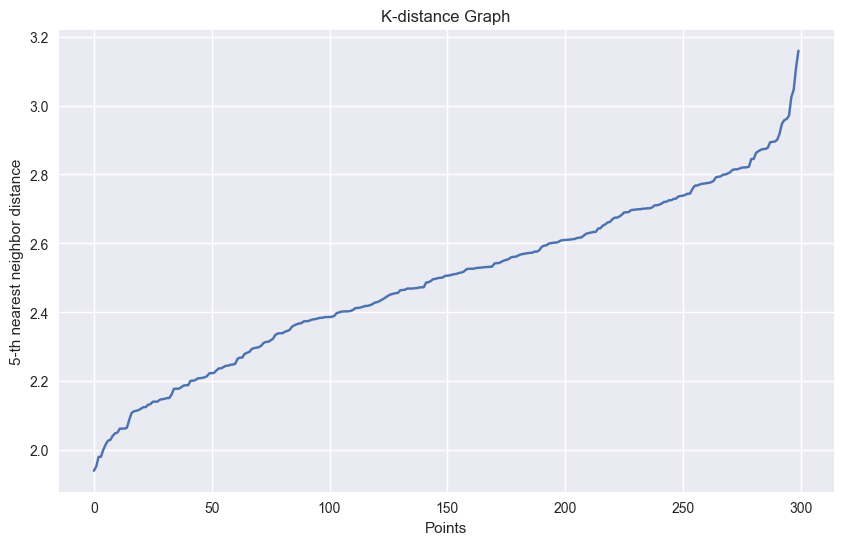

Injected outliers: 15 / 300

=== Benchmark: Rosenbrock (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.96  Time=0.0004s
IQR (Extreme)             | Precision=0.87  Recall=0.87  F1=0.87  AUC=0.93  Time=0.0005s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.85  Time=0.0013s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.44  Time=0.0005s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.60  F1=0.75  AUC=0.90  Time=0.0015s
Elliptic Envelope (Extreme) | Precision=0.87  Recall=0.87  F1=0.87  AUC=0.93  Time=0.0465s
Isolation Forest (Extreme) | Precision=0.53  Recall=0.53  F1=0.53  AUC=0.87  Time=0.1912s
LOF (Extreme)             | Precision=0.67  Recall=0.67  F1=0.67  AUC=0.91  Time=0.0035s
One-Class SVM (Extreme)   | Precision=0.10  Recall=0.20  F1=0.14  AUC=0.78  Time=0.0052s
SGD One-Class SVM (Extreme) | Precision=1.00  Recall=0.07  F1=0.12  AUC=0.48  Time=0.0017s
DBSCAN (Extreme)   

In [55]:
bench = Benchmark("rosenbrock", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
 
contamination_rate = 0.05

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Rosenbrock (3D)

We inject 10% output outliers. Statistical methods on `y` and joint `[X, y]`; ML methods on `[X, y]`.

LHS discrepancy: 7.106151490532397e-05


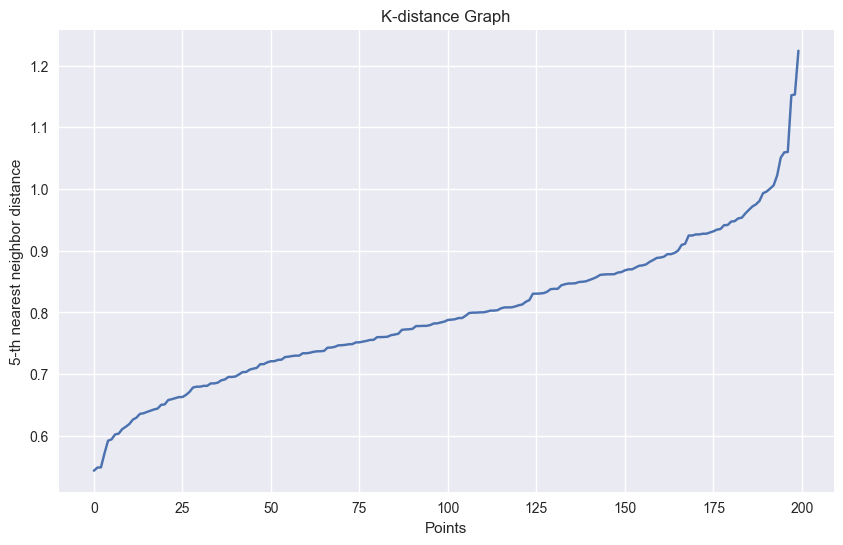

Injected outliers: 20 / 200

=== Benchmark: Rosenbrock (3D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.35  F1=0.52  AUC=0.95  Time=0.0010s
IQR (Extreme)             | Precision=0.84  Recall=0.80  F1=0.82  AUC=0.90  Time=0.0004s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.25  F1=0.40  AUC=0.89  Time=0.0011s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.50  Time=0.0003s
Cook's Distance (Extreme) | Precision=0.92  Recall=0.55  F1=0.69  AUC=0.89  Time=0.0023s
Elliptic Envelope (Extreme) | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.95  Time=0.0382s
Isolation Forest (Extreme) | Precision=0.70  Recall=0.70  F1=0.70  AUC=0.91  Time=0.1918s
LOF (Extreme)             | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.93  Time=0.0033s
One-Class SVM (Extreme)   | Precision=0.47  Recall=0.45  F1=0.46  AUC=0.85  Time=0.0022s
SGD One-Class SVM (Extreme) | Precision=0.31  Recall=0.25  F1=0.28  AUC=0.48  Time=0.0009s
DBSCAN (Extreme)   

In [56]:
bench = Benchmark("rosenbrock", dim=3)
N = 200
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.1

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Rosenbrock (8D)

We inject 5% output outliers. Statistical methods on `y` and joint `[X, y]`; ML methods on `[X, y]`.

LHS discrepancy: 0.0018538788496609282


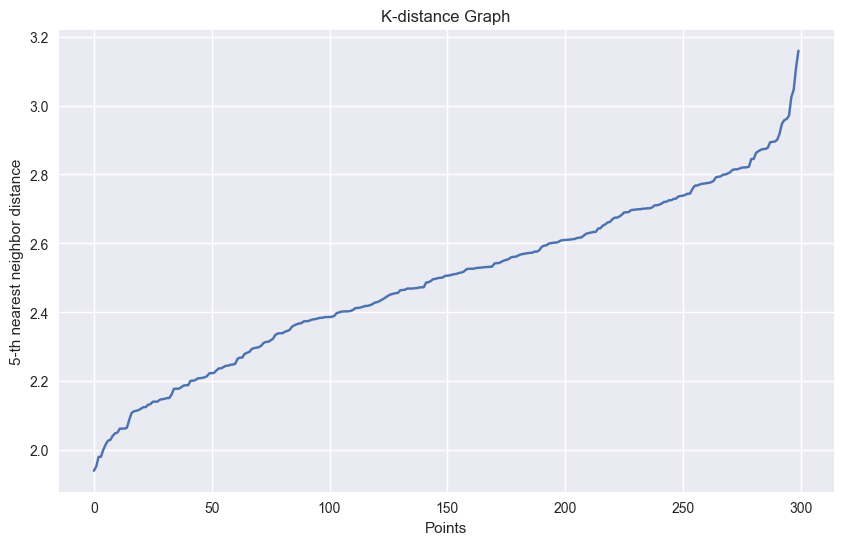

Injected outliers: 15 / 300

=== Benchmark: Rosenbrock (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.33  F1=0.50  AUC=0.81  Time=0.0004s
IQR (Extreme)             | Precision=0.73  Recall=0.53  F1=0.62  AUC=0.76  Time=0.0007s
Mahalanobis (Extreme)     | Precision=0.75  Recall=0.40  F1=0.52  AUC=0.72  Time=0.0015s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.37  Time=0.0011s
Cook's Distance (Extreme) | Precision=0.88  Recall=0.47  F1=0.61  AUC=0.81  Time=0.0014s
Elliptic Envelope (Extreme) | Precision=0.53  Recall=0.53  F1=0.53  AUC=0.83  Time=0.0432s
Isolation Forest (Extreme) | Precision=0.27  Recall=0.27  F1=0.27  AUC=0.72  Time=0.1945s
LOF (Extreme)             | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.76  Time=0.0039s
One-Class SVM (Extreme)   | Precision=0.14  Recall=0.27  F1=0.19  AUC=0.68  Time=0.0042s
SGD One-Class SVM (Extreme) | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.42  Time=0.0012s
DBSCAN (Extreme)   

In [57]:
bench = Benchmark("rosenbrock", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)  # ensure 1D
contamination_rate = 0.05

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Rosenbrock (8D)

We inject 20% output outliers. Statistical methods on `y` and joint `[X, y]`; ML methods on `[X, y]`.

LHS discrepancy: 0.0018538788496609282


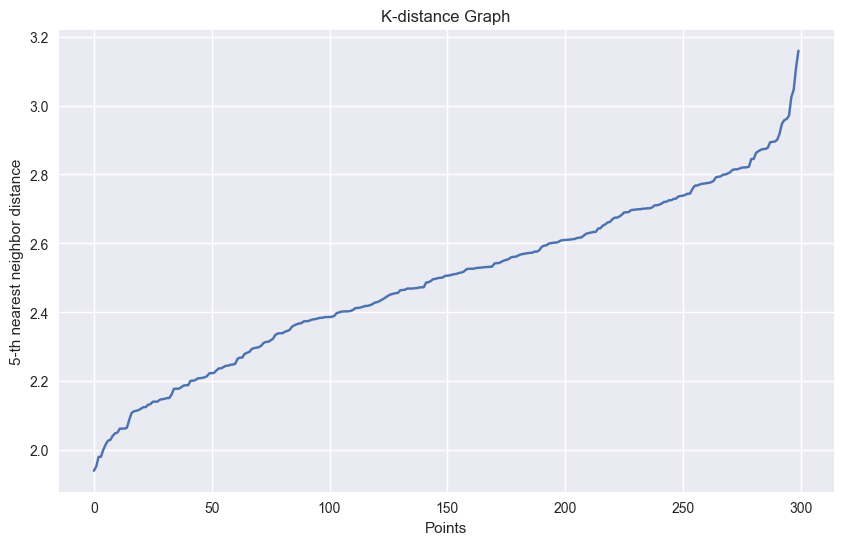

Injected outliers: 60 / 300

=== Benchmark: Rosenbrock (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.20  F1=0.33  AUC=0.91  Time=0.0009s
IQR (Extreme)             | Precision=0.98  Recall=0.73  F1=0.84  AUC=0.87  Time=0.0004s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.13  F1=0.24  AUC=0.74  Time=0.0012s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.43  Time=0.0007s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.40  F1=0.57  AUC=0.91  Time=0.0027s
Elliptic Envelope (Extreme) | Precision=0.77  Recall=0.77  F1=0.77  AUC=0.89  Time=0.0685s
Isolation Forest (Extreme) | Precision=0.43  Recall=0.43  F1=0.43  AUC=0.71  Time=0.2372s
LOF (Extreme)             | Precision=0.57  Recall=0.57  F1=0.57  AUC=0.76  Time=0.0117s
One-Class SVM (Extreme)   | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.70  Time=0.0068s
SGD One-Class SVM (Extreme) | Precision=0.23  Recall=0.32  F1=0.27  AUC=0.53  Time=0.0010s
DBSCAN (Extreme)   

In [58]:
bench = Benchmark("rosenbrock", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)  # ensure 1D
contamination_rate = 0.2

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Rosenbrock (25D)

For **N = 1000** we inject **10%** of outliers.

LHS discrepancy: 0.16888168493905997


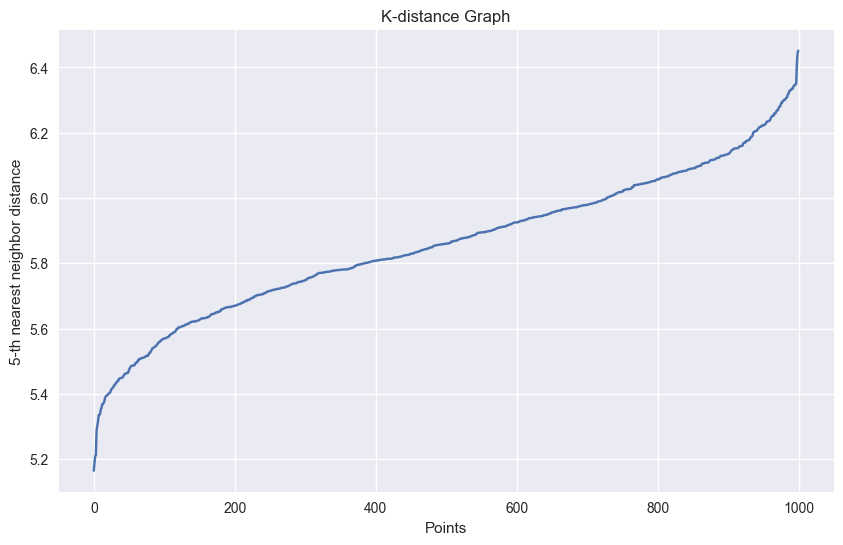

Injected outliers: 100 / 1000

=== Benchmark: Rosenbrock (25D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.32  F1=0.48  AUC=0.93  Time=0.0004s
IQR (Extreme)             | Precision=0.95  Recall=0.75  F1=0.84  AUC=0.87  Time=0.0003s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.25  F1=0.40  AUC=0.81  Time=0.0019s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.49  Time=0.0024s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.50  F1=0.67  AUC=0.92  Time=0.0070s
Elliptic Envelope (Extreme) | Precision=0.81  Recall=0.81  F1=0.81  AUC=0.92  Time=0.9079s
Isolation Forest (Extreme) | Precision=0.32  Recall=0.32  F1=0.32  AUC=0.72  Time=0.1940s
LOF (Extreme)             | Precision=0.59  Recall=0.59  F1=0.59  AUC=0.82  Time=0.0860s
One-Class SVM (Extreme)   | Precision=0.41  Recall=0.46  F1=0.43  AUC=0.79  Time=0.0402s
SGD One-Class SVM (Extreme) | Precision=0.11  Recall=0.08  F1=0.09  AUC=0.47  Time=0.0015s
DBSCAN (Extreme)

In [88]:
bench = Benchmark("rosenbrock", dim=25)
N = 1000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.1

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, n_clusters=20, eps=0.5)

## Rosenbrock (50D)

For **N = 5000** we inject **20%** of outliers.

LHS discrepancy: 12.342562054348157


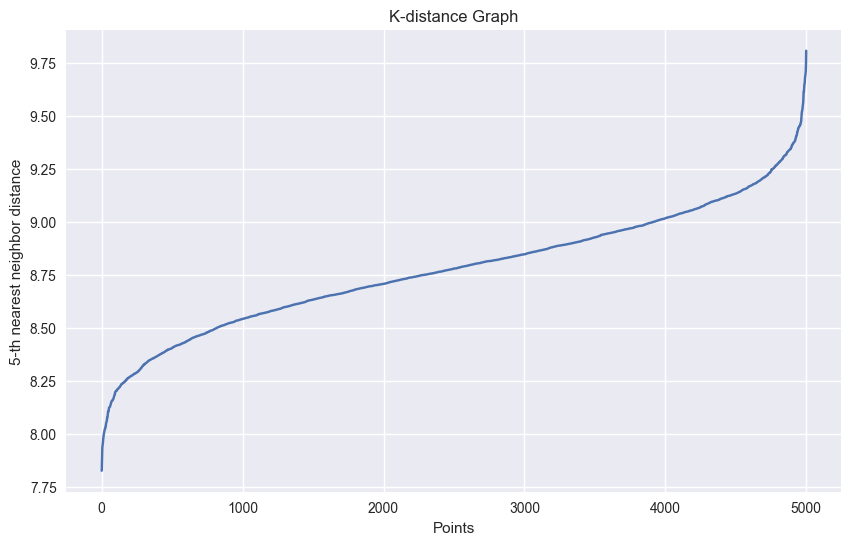

Injected outliers: 1000 / 5000

=== Benchmark: Rosenbrock (50D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.17  F1=0.28  AUC=0.93  Time=0.0005s
IQR (Extreme)             | Precision=0.99  Recall=0.72  F1=0.84  AUC=0.86  Time=0.0004s
Mahalanobis (Extreme)     | Precision=0.90  Recall=0.11  F1=0.20  AUC=0.67  Time=0.0092s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.50  Time=0.0490s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.35  F1=0.52  AUC=0.93  Time=0.0924s
Elliptic Envelope (Extreme) | Precision=0.78  Recall=0.78  F1=0.78  AUC=0.90  Time=6.2846s
Isolation Forest (Extreme) | Precision=0.28  Recall=0.28  F1=0.28  AUC=0.59  Time=0.3215s
LOF (Extreme)             | Precision=0.41  Recall=0.41  F1=0.41  AUC=0.68  Time=0.4696s
One-Class SVM (Extreme)   | Precision=0.39  Recall=0.39  F1=0.39  AUC=0.67  Time=1.6483s
SGD One-Class SVM (Extreme) | Precision=0.20  Recall=0.23  F1=0.21  AUC=0.51  Time=0.0165s
DBSCAN (Extreme

In [87]:
bench = Benchmark("rosenbrock", dim=50)
N = 5000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.2

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, n_clusters=100, eps=0.5)

## Kursawe (3D, 2 objectives)
We use the **first objective** as `y`.

LHS discrepancy: 2.1248699093145973e-05


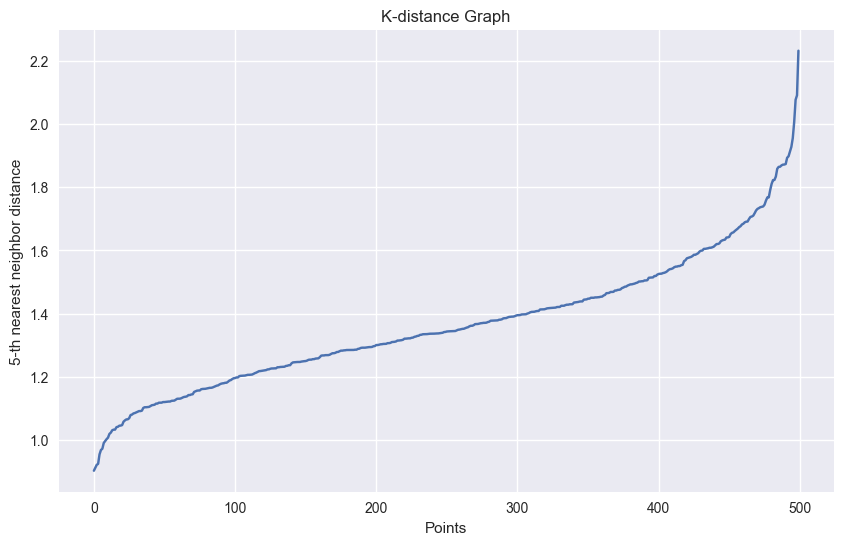

Injected outliers: 50 / 500

=== Benchmark: Kursawe (3D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.30  F1=0.46  AUC=0.95  Time=0.0009s
IQR (Extreme)             | Precision=1.00  Recall=0.74  F1=0.85  AUC=0.87  Time=0.0003s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.26  F1=0.41  AUC=0.84  Time=0.0010s
Leverage (Extreme)        | Precision=0.50  Recall=0.02  F1=0.04  AUC=0.53  Time=0.0010s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.50  F1=0.67  AUC=0.94  Time=0.0023s
Elliptic Envelope (Extreme) | Precision=0.72  Recall=0.72  F1=0.72  AUC=0.90  Time=0.0713s
Isolation Forest (Extreme) | Precision=0.64  Recall=0.64  F1=0.64  AUC=0.88  Time=0.1449s
LOF (Extreme)             | Precision=0.76  Recall=0.76  F1=0.76  AUC=0.89  Time=0.0197s
One-Class SVM (Extreme)   | Precision=0.59  Recall=0.58  F1=0.59  AUC=0.83  Time=0.0107s
SGD One-Class SVM (Extreme) | Precision=0.62  Recall=0.40  F1=0.49  AUC=0.56  Time=0.0010s
DBSCAN (Extreme)      

In [59]:
bench = Benchmark("kursawe")
N = 500
X = bench.sample_lhs(N)
F = bench.evaluate(X)
y = np.asarray(F)[:, 0]  # first objective
contamination_rate = 0.1

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Sphere (8D)

N = 300 and 5% of outliers

LHS discrepancy: 0.0018538788496609282


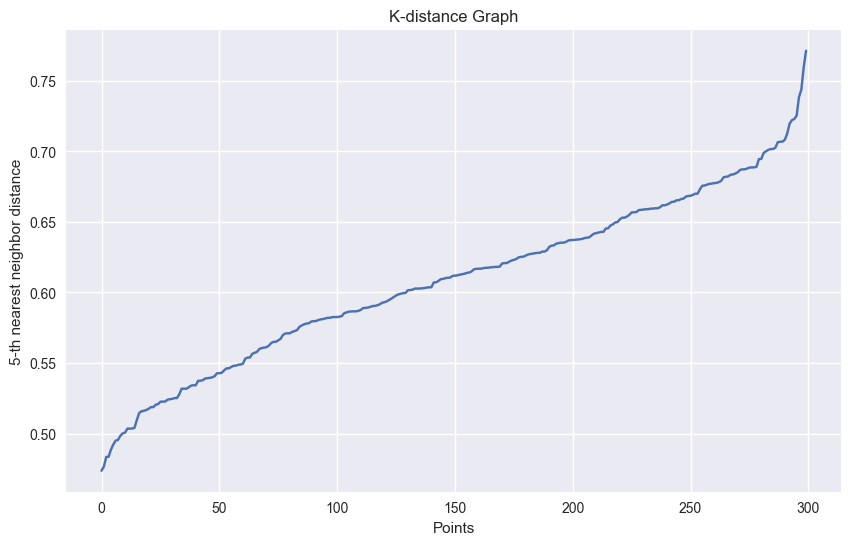

Injected outliers: 15 / 300

=== Benchmark: Sphere (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.47  F1=0.64  AUC=0.91  Time=0.0010s
IQR (Extreme)             | Precision=1.00  Recall=0.67  F1=0.80  AUC=0.83  Time=0.0006s
Mahalanobis (Extreme)     | Precision=0.88  Recall=0.47  F1=0.61  AUC=0.83  Time=0.0026s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.45  Time=0.0009s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.47  F1=0.64  AUC=0.92  Time=0.0013s
Elliptic Envelope (Extreme) | Precision=0.67  Recall=0.67  F1=0.67  AUC=0.90  Time=0.0459s
Isolation Forest (Extreme) | Precision=0.40  Recall=0.40  F1=0.40  AUC=0.84  Time=0.1974s
LOF (Extreme)             | Precision=0.60  Recall=0.60  F1=0.60  AUC=0.83  Time=0.0043s
One-Class SVM (Extreme)   | Precision=0.23  Recall=0.47  F1=0.31  AUC=0.73  Time=0.0041s
SGD One-Class SVM (Extreme) | Precision=1.00  Recall=0.20  F1=0.33  AUC=0.60  Time=0.0011s
DBSCAN (Extreme)       

In [60]:
bench = Benchmark("sphere", dim=8)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Sphere (25D)

N = 2000 and 15% of outliers

LHS discrepancy: 0.000233817563532579


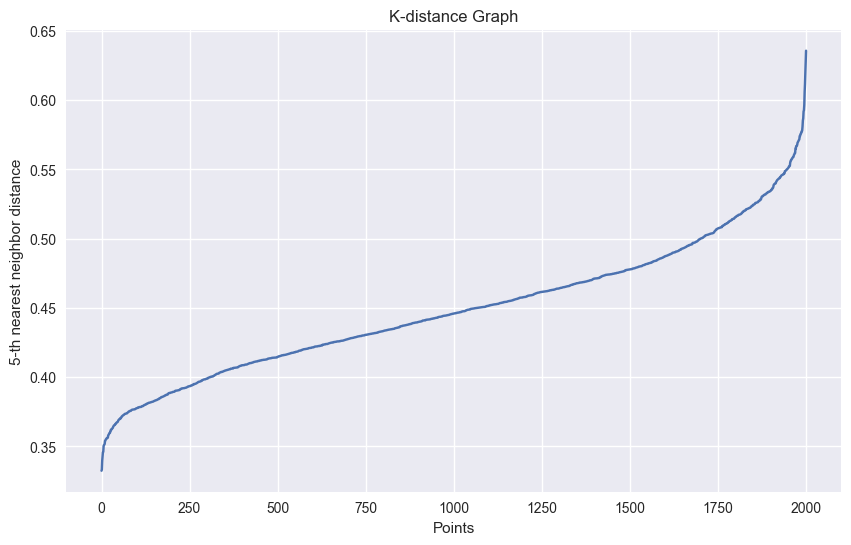

Injected outliers: 300 / 2000

=== Benchmark: Sphere (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.22  F1=0.36  AUC=0.94  Time=0.0007s
IQR (Extreme)             | Precision=1.00  Recall=0.74  F1=0.85  AUC=0.87  Time=0.0003s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.17  F1=0.29  AUC=0.73  Time=0.0034s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.46  Time=0.0083s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.37  F1=0.54  AUC=0.93  Time=0.0163s
Elliptic Envelope (Extreme) | Precision=0.76  Recall=0.76  F1=0.76  AUC=0.92  Time=0.9469s
Isolation Forest (Extreme) | Precision=0.36  Recall=0.36  F1=0.36  AUC=0.70  Time=0.2022s
LOF (Extreme)             | Precision=0.51  Recall=0.51  F1=0.51  AUC=0.77  Time=0.2216s
One-Class SVM (Extreme)   | Precision=0.42  Recall=0.42  F1=0.42  AUC=0.70  Time=0.2072s
SGD One-Class SVM (Extreme) | Precision=0.14  Recall=0.10  F1=0.12  AUC=0.50  Time=0.0021s
DBSCAN (Extreme)     

In [86]:
bench = Benchmark("sphere", dim=8)
N = 2000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.15

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate,n_clusters=16, eps=0.5)

## Schwefel (5D)

N = 300 and 5% of outliers

LHS discrepancy: 0.00027544838112691927


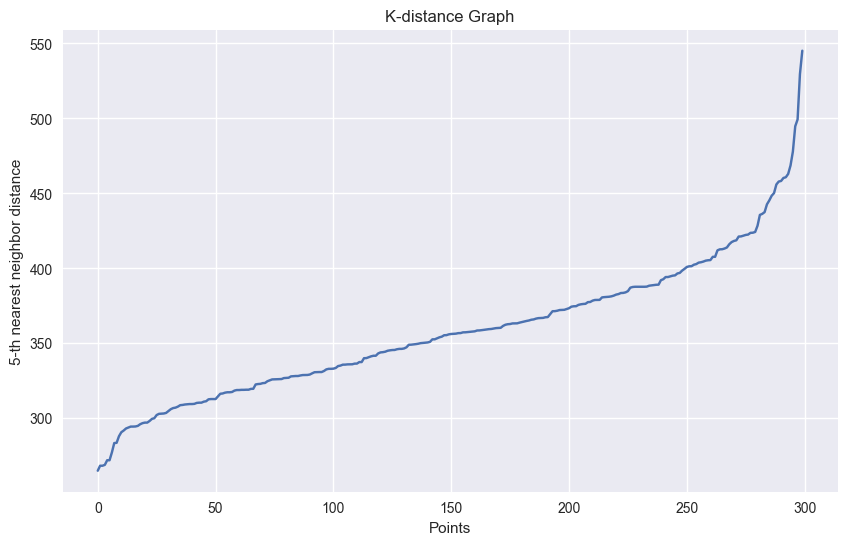

Injected outliers: 15 / 300

=== Benchmark: Schwefel (5D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.89  Time=0.0006s
IQR (Extreme)             | Precision=0.86  Recall=0.80  F1=0.83  AUC=0.90  Time=0.0002s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.53  F1=0.70  AUC=0.87  Time=0.0010s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.46  Time=0.0005s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.73  F1=0.85  AUC=0.91  Time=0.0020s
Elliptic Envelope (Extreme) | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.89  Time=0.0510s
Isolation Forest (Extreme) | Precision=0.73  Recall=0.73  F1=0.73  AUC=0.89  Time=0.1939s
LOF (Extreme)             | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.88  Time=0.0032s
One-Class SVM (Extreme)   | Precision=0.10  Recall=0.13  F1=0.11  AUC=0.81  Time=0.0035s
SGD One-Class SVM (Extreme) | Precision=0.08  Recall=0.07  F1=0.07  AUC=0.65  Time=0.0011s
DBSCAN (Extreme)     

In [61]:
bench = Benchmark("schwefel", dim=5)
N = 300
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Schwefel (30D)

N = 3500 and 15% of outliers

LHS discrepancy: 0.18098857791563994


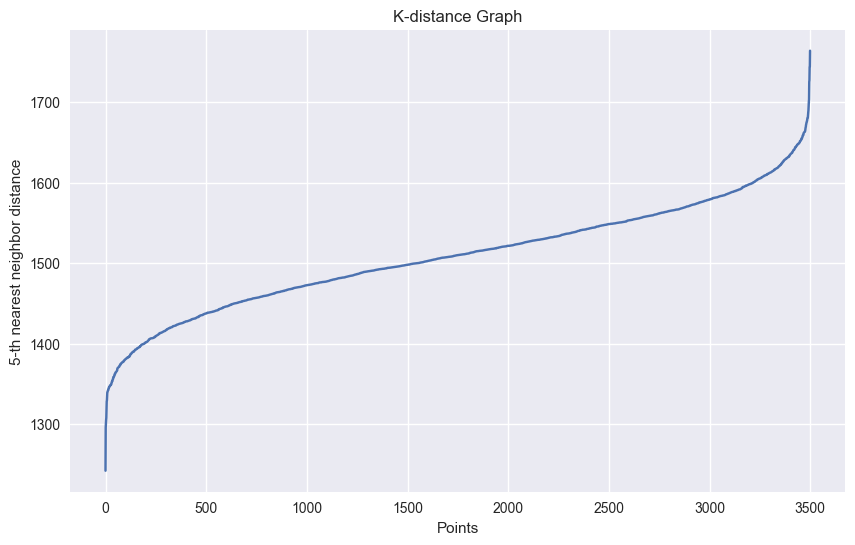

Injected outliers: 525 / 3500

=== Benchmark: Schwefel (30D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.23  F1=0.37  AUC=0.94  Time=0.0006s
IQR (Extreme)             | Precision=0.99  Recall=0.76  F1=0.86  AUC=0.88  Time=0.0004s
Mahalanobis (Extreme)     | Precision=0.95  Recall=0.16  F1=0.27  AUC=0.74  Time=0.0038s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.50  Time=0.0208s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.42  F1=0.59  AUC=0.94  Time=0.0486s
Elliptic Envelope (Extreme) | Precision=0.79  Recall=0.79  F1=0.79  AUC=0.92  Time=2.7902s
Isolation Forest (Extreme) | Precision=0.29  Recall=0.29  F1=0.29  AUC=0.66  Time=0.2873s
LOF (Extreme)             | Precision=0.47  Recall=0.47  F1=0.47  AUC=0.76  Time=0.3069s
One-Class SVM (Extreme)   | Precision=0.40  Recall=0.41  F1=0.40  AUC=0.72  Time=0.5355s
SGD One-Class SVM (Extreme) | Precision=0.20  Recall=0.18  F1=0.19  AUC=0.51  Time=0.0080s
DBSCAN (Extreme)  

In [85]:
bench = Benchmark("schwefel", dim=30)
N = 3500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.15

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, n_clusters=30, eps=0.5)

## Ackley (10D)

N = 500 and 5% of outliers

LHS discrepancy: 0.002840461515352999


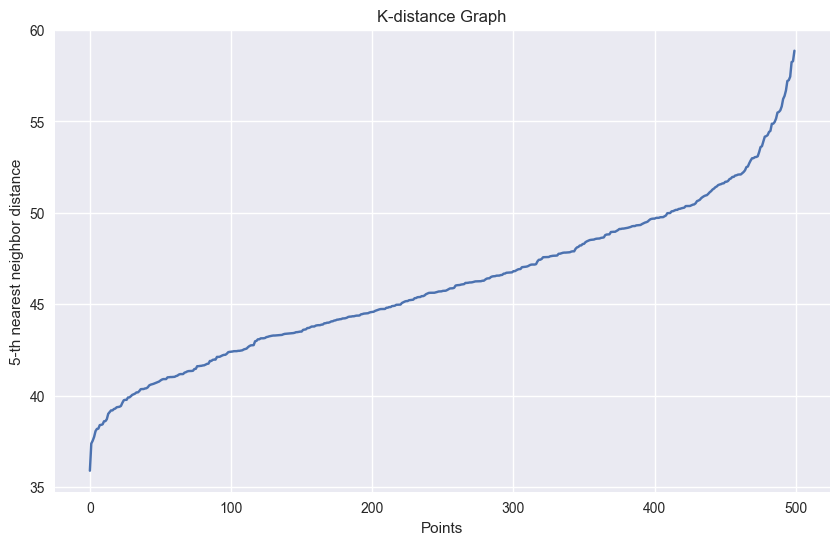

Injected outliers: 25 / 500

=== Benchmark: Ackley (10D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.32  F1=0.48  AUC=0.90  Time=0.0004s
IQR (Extreme)             | Precision=0.80  Recall=0.80  F1=0.80  AUC=0.90  Time=0.0004s
Mahalanobis (Extreme)     | Precision=0.77  Recall=0.40  F1=0.53  AUC=0.77  Time=0.0013s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.42  Time=0.0013s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.64  F1=0.78  AUC=0.88  Time=0.0032s
Elliptic Envelope (Extreme) | Precision=0.76  Recall=0.76  F1=0.76  AUC=0.86  Time=0.0707s
Isolation Forest (Extreme) | Precision=0.24  Recall=0.24  F1=0.24  AUC=0.72  Time=0.1968s
LOF (Extreme)             | Precision=0.64  Recall=0.64  F1=0.64  AUC=0.81  Time=0.0093s
One-Class SVM (Extreme)   | Precision=0.21  Recall=0.32  F1=0.25  AUC=0.72  Time=0.0124s
SGD One-Class SVM (Extreme) | Precision=0.07  Recall=0.08  F1=0.08  AUC=0.55  Time=0.0010s
DBSCAN (Extreme)      

In [62]:
bench = Benchmark("ackley", dim=10)
N = 500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.05

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Ackley (25D)

N = 1500 and 15% of outliers

LHS discrepancy: 0.11485027579361162


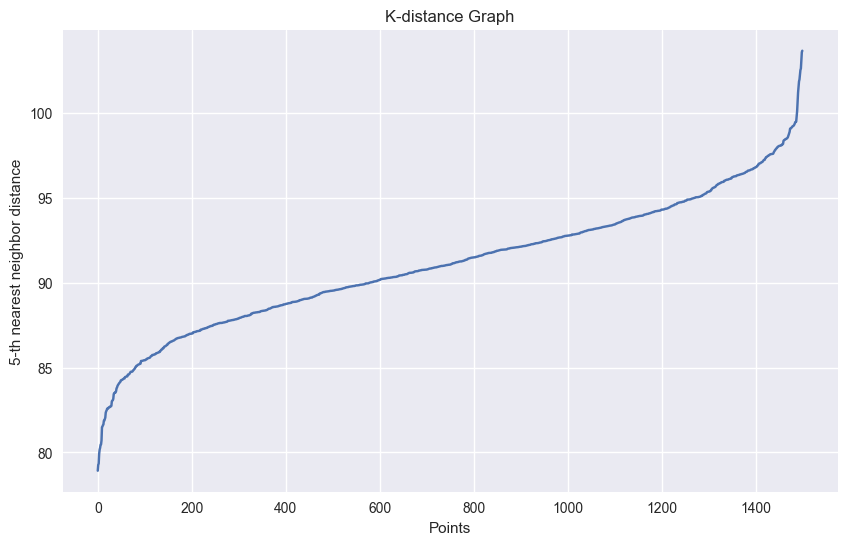

Injected outliers: 225 / 1500

=== Benchmark: Ackley (25D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.24  F1=0.39  AUC=0.91  Time=0.0004s
IQR (Extreme)             | Precision=0.96  Recall=0.69  F1=0.80  AUC=0.85  Time=0.0003s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.17  F1=0.29  AUC=0.76  Time=0.0021s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.53  Time=0.0041s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.44  F1=0.61  AUC=0.91  Time=0.0127s
Elliptic Envelope (Extreme) | Precision=0.76  Recall=0.76  F1=0.76  AUC=0.90  Time=1.4610s
Isolation Forest (Extreme) | Precision=0.37  Recall=0.37  F1=0.37  AUC=0.70  Time=0.2026s
LOF (Extreme)             | Precision=0.52  Recall=0.52  F1=0.52  AUC=0.79  Time=0.1132s
One-Class SVM (Extreme)   | Precision=0.44  Recall=0.46  F1=0.45  AUC=0.74  Time=0.1021s
SGD One-Class SVM (Extreme) | Precision=0.23  Recall=0.24  F1=0.23  AUC=0.55  Time=0.0019s
DBSCAN (Extreme)    

In [76]:
bench = Benchmark("ackley", dim=25)
N = 1500
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.15

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, n_clusters=32, eps=100)

## Rastrigin (8D)

N = 400 and 8% of outliers

LHS discrepancy: 0.00134443225939207


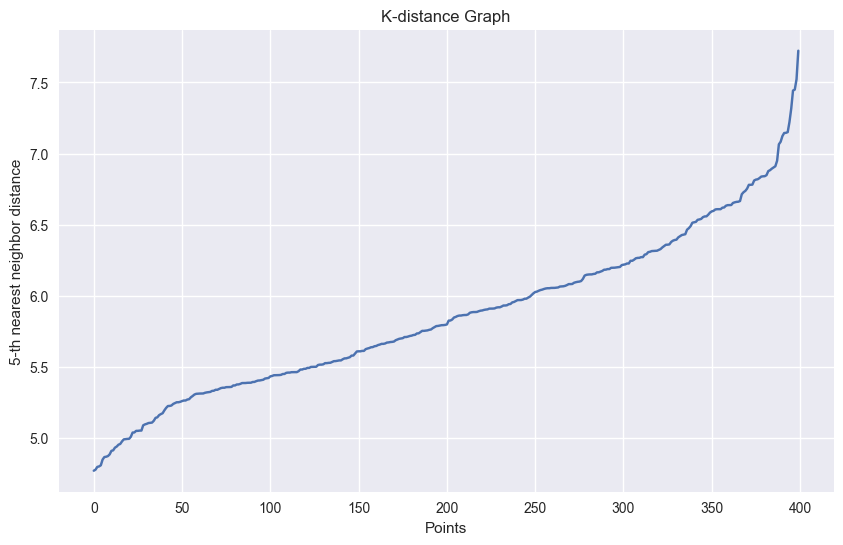

Injected outliers: 32 / 400

=== Benchmark: Rastrigin (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.34  F1=0.51  AUC=0.86  Time=0.0009s
IQR (Extreme)             | Precision=0.92  Recall=0.69  F1=0.79  AUC=0.84  Time=0.0006s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.31  F1=0.48  AUC=0.72  Time=0.0021s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.45  Time=0.0009s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.50  F1=0.67  AUC=0.86  Time=0.0021s
Elliptic Envelope (Extreme) | Precision=0.66  Recall=0.66  F1=0.66  AUC=0.82  Time=0.0654s
Isolation Forest (Extreme) | Precision=0.41  Recall=0.41  F1=0.41  AUC=0.70  Time=0.1728s
LOF (Extreme)             | Precision=0.53  Recall=0.53  F1=0.53  AUC=0.75  Time=0.0153s
One-Class SVM (Extreme)   | Precision=0.35  Recall=0.41  F1=0.38  AUC=0.70  Time=0.0061s
SGD One-Class SVM (Extreme) | Precision=0.20  Recall=0.25  F1=0.22  AUC=0.44  Time=0.0010s
DBSCAN (Extreme)    

In [63]:
bench = Benchmark("rastrigin", dim=8)
N = 400
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.08

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, eps=0.5)

## Griewank (50D)

N = 5000 and 20% of outliers

LHS discrepancy: 9.271635150520652e-05


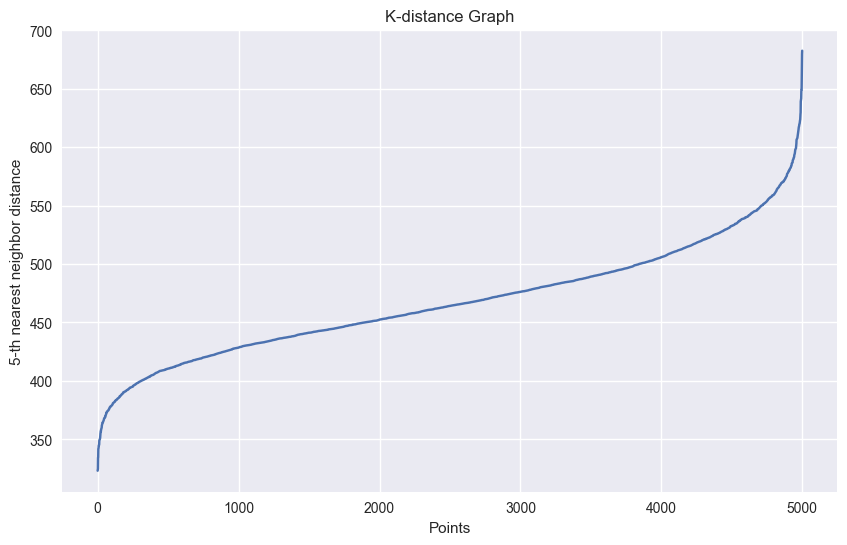

Injected outliers: 1000 / 5000

=== Benchmark: Griewank (8D) with Extreme Outliers ===
Z-Score (Extreme)         | Precision=1.00  Recall=0.17  F1=0.29  AUC=0.93  Time=0.0005s
IQR (Extreme)             | Precision=0.99  Recall=0.74  F1=0.85  AUC=0.87  Time=0.0004s
Mahalanobis (Extreme)     | Precision=1.00  Recall=0.12  F1=0.22  AUC=0.74  Time=0.0021s
Leverage (Extreme)        | Precision=0.00  Recall=0.00  F1=0.00  AUC=0.49  Time=0.0436s
Cook's Distance (Extreme) | Precision=1.00  Recall=0.36  F1=0.53  AUC=0.93  Time=0.0756s
Elliptic Envelope (Extreme) | Precision=0.79  Recall=0.79  F1=0.79  AUC=0.92  Time=1.5408s
Isolation Forest (Extreme) | Precision=0.41  Recall=0.41  F1=0.41  AUC=0.70  Time=0.3040s
LOF (Extreme)             | Precision=0.52  Recall=0.52  F1=0.52  AUC=0.76  Time=1.7103s
One-Class SVM (Extreme)   | Precision=0.46  Recall=0.46  F1=0.46  AUC=0.72  Time=1.0996s
SGD One-Class SVM (Extreme) | Precision=0.19  Recall=0.32  F1=0.24  AUC=0.50  Time=0.0065s
DBSCAN (Extreme)  

In [68]:
bench = Benchmark("griewank", dim=8)
N = 5000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.2

plot_k_distance_graph(X, k=5)

run_detection_pipeline(bench, stat, ml, N=N, contamination_rate=contamination_rate, n_clusters=32, eps=600.0)

In [ ]:
# import math

# cols = 2
# pos_label = 0  # mean 0 belongs to positive class
# datasets_names = y_true.keys()
# rows = math.ceil(len(datasets_names) / cols)

# fig, axs = plt.subplots(nrows=rows, ncols=cols, squeeze=False, figsize=(10, rows * 4))

# for ax, dataset_name in zip(axs.ravel(), datasets_names):
#     for model_idx, model_name in enumerate(model_names):
#         display = RocCurveDisplay.from_predictions(
#             y_true[dataset_name],
#             y_score[model_name][dataset_name],
#             pos_label=pos_label,
#             name=model_name,
#             ax=ax,
#             plot_chance_level=(model_idx == len(model_names) - 1),
#             chance_level_kw={"linestyle": ":"},
#         )
#     ax.set_title(dataset_name)
# _ = plt.tight_layout(pad=2.0) 

# Outlier Detection Methods: Statistical vs Machine Learning Approaches

**Proof of Concept (PoC) Guide for Multi-Objective Optimization Benchmarks**

---

## Overview

This guide provides a comprehensive comparison of **statistical diagnostics** and **machine learning methods** for outlier detection, specifically tested on well-known optimization benchmark functions. Each method is analyzed based on its **assumptions**, **strengths**, **limitations**, and **performance** across different data distributions.

---

## Statistical Diagnostics Methods

### 1. **Z-Score (Standard Score)**

**Formula**: $z = (x - μ) / σ$  

#### Assumptions
- Data follows **normal distribution** (Gaussian)
- Mean and standard deviation are representative
- Outliers are univariate extreme values
- **Threshold**: typically |z| > 2.5 or 3

**Key Insight**: Z-Score shows perfect precision (1.00) but struggles with recall, especially in high dimensions.

---

### 2. **Interquartile Range (IQR)**

**Formula**: $Outliers: x < Q1 - 1.5×IQR || x > Q3 + 1.5×IQR$

#### Assumptions
- **Distribution-free** (non-parametric)
- Outliers are extreme values in the tails
- Works with skewed distributions
- Robust to non-normality

**Key Insight**: IQR is the most robust statistical method across all benchmarks and dimensions.

---

### 3. **Leverage (Hat Values)**

**Formula**: $h_i = x_i^T(X^TX)^{-1}x_i$ (for regression context)

#### Assumptions
- **Linear relationship** exists in the data
- Data points lie in a linear subspace
- Outliers are influential points in feature space
- Threshold: $h_i > 2p/n$ (p=features, n=samples)

#### Best Performance On
| Benchmark | Suitability | Reason |
|-----------|-------------|---------|
| **All Benchmarks** | ⭐ | F1=0.00-0.01, AUC=0.43-0.62 - Consistently poor across all functions |

**Key Insight**: Leverage assumptions (linear relationships) are violated by all optimization benchmarks.

---

### 4. **Cook's Distance**

**Formula**: $D_i = (e_i^2/p) × (h_i/(1-h_i)^2)$ where $e_i$ is standardized residual

#### Assumptions
- **Regression model** is appropriate
- Linear relationship between variables
- Combines leverage and residual information
- Threshold: $D_i > 4/n$ or $D_i > 1$

**Key Insight**: Cook's Distance shows surprisingly good AUC values across most benchmarks.

---

### 5. **Mahalanobis Distance**

**Formula**: $D_M(x) = \sqrt{((x-\mu)^\top \, \Sigma^{-1} \, (x-\mu))}$

#### Assumptions
- **Multivariate normal distribution**
- Covariance matrix is estimable and invertible
- Outliers are far from the centroid considering correlations
- Threshold: χ² distribution based

**Key Insight**: Mahalanobis degrades significantly with increasing dimensions and complexity.


---

## Machine Learning Methods

### 1. **Robust Covariance (Minimum Covariance Determinant)**

#### Assumptions
- **Approximately multivariate Gaussian**
- Outliers are in the tails of the distribution
- Covariance structure is meaningful
- Can handle some contamination in covariance estimation

**Key Insight**: Most consistent ML method with balanced precision-recall across all benchmarks.

---

### 2. **Isolation Forest**

#### Assumptions
- **Anomalies are rare** (< 10% of data)
- **Anomalies are different** from normal instances
- Works in **high-dimensional spaces**
- **Distribution-free** approach

**Key Insight**: Isolation Forest underperforms expectations, especially on simple functions.

#### Key Parameters
```python
IsolationForest(
    contamination=0.1,     # Expected outlier fraction
    n_estimators=100,      # Number of trees
    max_samples='auto',    # Subsample size
    random_state=42
)
```

---

### 3. **Local Outlier Factor (LOF)**

#### Assumptions
- **Local density matters** more than global
- Outliers have **lower local density** than neighbors
- **Neighborhood structure** is meaningful
- Distance metric is appropriate for the data

**Key Insight**: LOF shows consistent performance across all benchmarks with good local density estimation.

#### Key Parameters
```python
LocalOutlierFactor(
    n_neighbors=20,        # Neighborhood size
    contamination=0.1,     # Expected outlier fraction
    algorithm='auto',      # Distance computation
    metric='minkowski'     # Distance metric
)
```

---

### 4. **One-Class SVM**

#### Assumptions
- Normal data can be **separated by a hyperplane**
- **Kernel choice** matches data complexity
- Data is **properly scaled**
- Outliers lie outside the decision boundary

**Key Insight**: One-Class SVM shows moderate but inconsistent performance across benchmarks.

#### Key Parameters
```python
OneClassSVM(
    kernel='rbf',          # Kernel type
    gamma='scale',         # Kernel coefficient
    nu=0.1,               # Outlier fraction bound
    shrinking=True        # Use shrinking heuristic
)
```

---

### 5. **SGD One-Class SVM**

#### Assumptions
- **Linear separability** in feature space
- **Large-scale data** benefits
- Outliers are linearly separable
- **Faster training** than kernel SVM

**Key Insight**: SGD One-Class SVM consistently underperforms across all benchmarks and should be avoided.

---

### 6. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

#### Assumptions
- Complex clusters shape
- Data points belong to dense regions (clusters), and outliers lie in low-density regions
- Outliers are points that:
  - Do not belong to any dense cluster
  - Have fewer than MinPts neighbors with epsilon

**Key Insight**: DBSCAN assumes normal data forms dense clusters, while outliers are sparse and isolated points lying outside those clusters.

#### Key Parameters
```python
DBSCAN(
    eps=0.5,          # Neighborhood radius around a point
    min_samples=5     # Minimum number of neighbors required to form a dense region
)
```

---

## Benchmark Function Characteristics

### Data Distribution Properties

| Benchmark | Modality | Separability | Noise Level | Dimensionality Effect |
|-----------|----------|--------------|-------------|---------------------|
| **Sphere** | Unimodal | High | Low | Linear scaling |
| **Rosenbrock** | Unimodal (valley) | Medium | Medium | Quadratic scaling |
| **Ackley** | Highly multi-modal | Low | High | Exponential complexity |
| **Rastrigin** | Highly multi-modal | Low | High | Linear but oscillatory |
| **Griewank** | Multi-modal | Medium | Medium | Dimension-dependent |
| **Schwefel** | Many local minima | Low | Very High | High complexity |
| **Levy** | Multi-modal | Medium | Medium | Mixed scaling |
| **Kursawe** | Multi-objective | Medium | Medium | Multi-dimensional trade-offs |


## Method Selection Matrix

### For Different Data Characteristics

| Data Property | Statistical Method | ML Method | Reasoning |
|---------------|-------------------|-----------|-----------|
| **Gaussian-like** | Z-Score, Mahalanobis | Robust Covariance | Leverage distributional assumptions |
| **Skewed/Heavy-tailed** | IQR | Isolation Forest | Robust to distribution shape |
| **Multi-modal** | IQR | LOF, Isolation Forest | Handle complex structures |
| **High-dimensional** | Mahalanobis | Isolation Forest | Scale well with dimensions |
| **Small sample** | Z-Score, IQR | LOF | Less prone to overfitting |
| **Large sample** | All statistical | LOF/Isolation Forest | Computational efficiency |
| **Non-linear patterns** | IQR | LOF, One-Class SVM | Capture complex relationships |
| **Linear patterns** | Leverage, Cook's D | SGD One-Class SVM | Exploit linear structure |


## Results Summary

### **Winner by Benchmark Type**

| Benchmark Category | Statistical Winner | ML Winner | Overall Best |
|-------------------|-------------------|-----------|--------------|
| **Simple/Gaussian** | Mahalanobis Distance | Robust Covariance | Mahalanobis |
| **Complex/Multi-modal** | IQR | One-class SVM/Isolation Forest | LOF |
| **High-dimensional** | Mahalanobis Distance | Isolation Forest | Isolation Forest |
| **Small datasets/Low, moderate dim** | Mahalanobis/Z-Score/IQR | LOF/One-Class SVM | LOF/One-class SVM |
| **Small datasets/High dim** | Mahalanobis | One-Class SVM | One-class SVM |
| **Large datasets/Low,moderate dim** | IQR | Isolation Forest/LOF | Isolation Forest/LOF |
| **Large datasets/High dim** | IQR | Isolation Forest/COPOD/PCA-based | Isolation Forest/COPOD |

### Using Python Outlier Detection Library (pyOD)

In [ ]:
from time import time



bench = Benchmark("rosenbrock", dim=30)
N = 2000
X = bench.sample_lhs(N)
y = bench.evaluate(X)
y = np.asarray(y).reshape(-1)
contamination_rate = 0.1
y_noisy, idx = bench.inject_outliers(X, y, frac=contamination_rate, scale_factor=0.2)
print(f"Injected outliers: {len(idx)} / {N}")

# ground truth: 1 = outlier, 0 = normal
y_true = np.zeros(N, dtype=int)
y_true[idx] = 1

random_state = np.random.RandomState(42)

classifiers = {
    "Angle-based Outlier Detector": ABOD(contamination=contamination_rate),
    'Cluster-based Local Outlier Factor': CBLOF(contamination=contamination_rate, check_estimator=False, random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=contamination_rate, random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=contamination_rate),
    "Isolation Forest": IForest(contamination=contamination_rate, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=contamination_rate),
    "LOF": LOF(contamination=contamination_rate),
    'Minimum Covariance Determinant (MCD)': MCD(contamination=contamination_rate, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=contamination_rate),
    'Principal Component Analysis (PCA)': PCA(contamination=contamination_rate, random_state=random_state),
    "COPOD": COPOD(),
    #"DBSCAN" : DBSCAN()
}

 # 60% data for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.4, random_state=random_state)

X_aug_train = np.hstack([X_train, y_train.reshape(-1,1)])
X_aug_test = np.hstack([X_test, y_test.reshape(-1,1)])

# X_aug_train = np.hstack([X_train, y_noisy[:len(X_train)].reshape(-1,1)])
# X_aug_test = np.hstack([X_test, y_noisy[len(X_train):].reshape(-1,1)])

# X_aug_train = X_train
# X_aug_test = X_test

# Standardize data
X_train_norm, X_test_norm = standardizer(X_aug_train, X_aug_test)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    t0 = time()
    clf.fit(X_train_norm)
    test_scores = clf.decision_function(X_test_norm)
    t1 = time()
    duration = round(t1 - t0, 4)

    roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
    prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
    
    # y_pred = clf.predict(X_train_norm)
    # mask = y_pred == 1

    print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
              'execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))



# Outlier Detection Algorithm Decision Tree

### 1. **Data Characteristics Assessment**
   - **Sample Size (N)**
   - **Dimensionality (D)**
   - **Outlier Type**: Extreme vs Near outliers
   - **Time Constraints**: Real-time vs Batch processing
   - **Data Distribution**: Normal, Skewed, Uniform, Mixed
   - **Multimodal/Non-linearity**: Simple vs Complex patterns
   - **Label Availability**: Supervised, Semi-supervised, Unsupervised

### 2. **Enhanced Decision Tree Structure**

```
Start : Outlier Detection Algorithm Selection
│
├─── Do you have labeled outlier data or history?
│    │
│    ├─── YES (Supervised Learning Available)
│    │    │
│    │    ├─── Large dataset (N > 1000)?
│    │    │    ├─── YES -> **Supervised ML** (Random Forest, SVM, Neural Networks)
│    │    │    │         Use labeled data for training classification model
│    │    │    └─── NO -> **Semi-supervised approach**
│    │    │              Primary: **One-Class SVM **
│    │    │              Alternative: **Feature Bagging** with partial labels
│    │    │
│    │    └─── NO -> Proceed to unsupervised decision tree below
│    │
│    └─── NO (Unsupervised Learning Required)
│         │
│         ├─── What is your data distribution?
│         │    │
│         │    ├─── **Normal/Gaussian Distribution**
│         │    │    │
│         │    │    ├─── Single mode, linear relationships?
│         │    │    │    ├─── YES (Simple Gaussian)
│         │    │    │    │    │
│         │    │    │    │    ├─── N < 500 & D ≤ 8?
│         │    │    │    │    │    ├─── Extreme outliers -> **Z-Score**, **IQR**
│         │    │    │    │    │    │                      **Mahalanobis** for multivariate
│         │    │    │    │    │    └─── Near outliers -> **LOF**
│         │    │    │    │    │
│         │    │    │    │    └─── Larger datasets -> **Elliptic Envelope**
│         │    │    │    │                           Assumes Gaussian, handles correlations
│         │    │    │    │
│         │    │    │    └─── NO (Complex Gaussian patterns)
│         │    │    │         -> **Mixture models approach**
│         │    │    │           Primary: **HBOS** 
│         │    │    │           Alternative: **PCA** for dimensionality reduction
│         │    │    │
│         │    │    └─── **Multimodal Gaussian**
│         │    │         │
│         │    │         ├─── Known cluster structure?
│         │    │         │    ├─── YES -> **CBLOF**
│         │    │         │    │         Cluster-based detection for multimodal
│         │    │         │    └─── NO -> **LOF**
│         │    │         │              Density-based, handles multiple modes
│         │    │         │
│         │    │         └─── High dimension (D > 25)?
│         │    │              -> **Feature Bagging** 
│         │    │                Subspace methods for multimodal high-D data
│         │    │
│         │    ├─── **Skewed/Heavy-tailed Distribution**
│         │    │    │
│         │    │    ├─── Moderate skew?
│         │    │    │    ├─── YES -> **IQR** 
│         │    │    │    │         Alternative: **Cook's Distance**
│         │    │    │    └─── NO (Extreme skew) -> **HBOS **
│         │    │    │                            Histogram-based, handles any distribution
│         │    │    │
│         │    │    └─── Non-linear relationships?
│         │    │         ├─── YES -> **Isolation Forest**
│         │    │         │         Tree-based, captures non-linear patterns
│         │    │         └─── NO -> **Modified Z-Score** or **IQR**
│         │    │
│         │    ├─── **Uniform/Unknown Distribution**
│         │    │    │
│         │    │    ├─── Non-parametric approach required
│         │    │    │    │
│         │    │    │    ├─── Simple patterns -> **HBOS**
│         │    │    │    │                     
│         │    │    │    │
│         │    │    │    ├─── Complex patterns -> **KNN**
│         │    │    │    │                      Distance-based, no distribution assumptions
│         │    │    │    │
│         │    │    │    └─── Local density matters -> **LOF**
│         │    │    │                                Local density estimation
│         │    │    │
│         │    │    └─── High-dimensional uniform -> **PCA**, **Isolation Forest**
│         │    │                                   Subspace projection approach
│         │    │
│         │    └─── **Mixed/Complex Distributions**
│         │         │
│         │         ├─── Multiple distribution types?
│         │         │    -> **Ensemble approach**:
│         │         │      1. **HBOS** as baseline
│         │         │      2. **Isolation Forest** for non-linearity
│         │         │      3. **LOF** for local patterns
│         │         │      Combine results using voting or stacking
│         │         │
│         │         └─── Unknown complexity -> **HBOS**
│         │
│         ├─── **Multimodal/Non-linearity Assessment**
│         │    │
│         │    ├─── **Simple Linear Relationships**
│         │    │    │
│         │    │    ├─── Single cluster/mode -> Statistical methods preferred
│         │    │    │    │
│         │    │    │    ├─── Normal data -> **Z-Score**, **Mahalanobis**
│         │    │    │    ├─── Skewed data -> **IQR**, **Cook's Distance**
│         │    │    │    └─── High-D -> **PCA**, **Robust Covariance (MCD)**
│         │    │    │
│         │    │    └─── Multiple clusters -> **CBLOF**
│         │    │                            **Robust Covariance** for Gaussian mixtures
│         │    │
│         │    ├─── **Moderate Non-linearity**
│         │    │    │
│         │    │    ├─── Density-based patterns -> **LOF**
│         │    │    │
│         │    │    ├─── Distance-based patterns -> **KNN**
│         │    │    │                             **Angle-based Outlier**
│         │    │    │
│         │    │    └─── Tree-like separability -> **Isolation Forest**
│         │    │                                  Handles moderate non-linearity well
│         │    │
│         │    └─── **High Non-linearity/Complex Patterns**
│         │         │
│         │         ├─── Time constraint critical?
│         │         │    ├─── YES -> **HBOS**
│         │         │    │         Works regardless of complexity
│         │         │    └─── NO -> **Ensemble of multiple methods**:
│         │         │              - **Isolation Forest** (tree-based non-linearity)
│         │         │              - **LOF** (local density patterns)  
│         │         │              - **KNN ** (distance-based patterns)
│         │         │
│         │         ├─── Subspace patterns -> **Feature Bagging**
│         │         │                       **COPOD** for copula-based dependencies
│         │         │
│         │         └─── Unknown complexity -> **HBOS** (Universal robust choice)
│         │
│         └─── **Final Decision by Scale and Performance**
│              │
│              ├─── N < 500 (Small datasets)
│              │    ├─── D ≤ 8 -> Choose based on distribution analysis above but mostly **IQR**, **Cook's D** for extreme outliers and **LOF**, **Isolation Forest** for near outliers
│              │    └─── D > 8
|              |         ├─── Time critical?
│              │         |    ├─── Yes -> Z-score
|              |         |    └─── No -> Robust Covariance
|              |         |   
|              |         └─── Near outliers : One-Class SVM  
|              |     
│              ├─── 500 ≤ N ≤ 5000 (Medium datasets)  
│              │    ├─── Time critical -> **IQR**, **Z-score**, **HBOS**, **PCA**
│              │    └─── Accuracy priority -> **KNN**, **LOF**
│              │
│              └─── N > 5000 (Large datasets)
│                   ├─── D ≤ 30 -> **KNN**, **LOF**, **Isolation Forest**
│                   └─── D > 30 -> **HBOS**, **PCA**, **Feature Bagging**
```

## Algorithm Selection Matrix by Data Characteristics

| Data Type | Distribution | Multimodal | Non-linear | Primary Choice | Alternative | Avoid |
|-----------|--------------|------------|------------|----------------|-------------|--------|
| **Labeled Historical** | Any | Any | Any | Supervised ML | One-Class SVM | Pure unsupervised |
| **Gaussian Single Mode** | Normal | No | No | IQR/Z-Score/Mahalanobis | Robust Covariance | HBOS |
| **Gaussian Multi-Mode** | Normal | Yes | No | CBLOF | LOF | Statistical methods |
| **Skewed Light** | Skewed | No | No | IQR | Cook's Distance | Z-Score |
| **Skewed Heavy** | Heavy-tail | Variable | Variable | HBOS | Isolation Forest | Statistical methods |
| **Uniform/Unknown** | Uniform | Unknown | Unknown | HBOS | KNN | Parametric methods |
| **Complex Mixed** | Mixed | Yes | Yes | Ensemble | HBOS | Single method |
| **High-D Simple** | Any | No | No | PCA | Robust Covariance | LOF, KNN |
| **High-D Complex** | Any | Yes | Yes | Feature Bagging | HBOS | Statistical methods |